# Contents

>[Contents](#scrollTo=ISfvEc6QTF3-)

>[Imports and Setup](#scrollTo=LzQFZNKL0uHb)

>[Create the Sphere Mesh](#scrollTo=ToNMP7mC797Y)

>[Create the renderer](#scrollTo=avCqYaNn8fi7)

>[Create a basic ML model](#scrollTo=NOyG2PbN-NXI)

>>[Helper functions](#scrollTo=PwjQaIA9SNSS)

>>[Train and test loops](#scrollTo=_McEInbeBvJR)

>[Experiments](#scrollTo=0ni9zstuIsfs)

>>[Color optimization](#scrollTo=VD1GowEog3hQ)

>>>[Optimizing only the weights (baseline)](#scrollTo=lAuhSR-TSelq)

>>>[Optimizing the colors and the weights simultaneously](#scrollTo=aZLeUrEfSDlY)

>>[Color optimization (monochrome initial color)](#scrollTo=VUlpgyWFIcvF)

>>>[Optimizing only the weights](#scrollTo=yJRkbLR-IiYr)

>>>[Optimizing the colors and the weights simultaneously](#scrollTo=lfcblmj7KaYb)

>>[Shape optimization](#scrollTo=bhN4Vw7UA43V)

>>>[Optimizing the shape and the weights simultaneously](#scrollTo=2Oy6BEHMCIsM)

>>>[Optimizing the shape and the weights simultaneously with smoothing (smoothing_weight = 1)](#scrollTo=lZ7-6V56CBLs)

>>>[Optimizing the shape and the weights simultaneously with smoothing (smoothing_weight = 1.25)](#scrollTo=Xe7_9R4HnRj-)

>>>[Optimizing the shape and the weights simultaneously with smoothing (smoothing_weight = 1.5)](#scrollTo=IGi_-6JVhtfY)

>>[Color and shape optimization](#scrollTo=N4UWNZa2NbJU)

>>>[Optimizing the colors, shape and weights simultaneously](#scrollTo=HKp6KakzNgRz)

>>>[Optimizing the colors, shape and weights simultaneously with smoothing](#scrollTo=cEkXMAViRbhs)

>>[Controlling deformations](#scrollTo=z3I7bHZNgvEL)

>>>[x-axis deform](#scrollTo=VX89reKG8E1k)

>>>[x-, y-, and z-axis deform](#scrollTo=zpJitYWN8Jy6)



# Imports and Setup

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.2.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-gj5jd_te
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-gj5jd_te
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp311-cp311-linux_x86_64.whl size=60242856 sha256=6f7149d96231d278829d023c5a2021aeb5fb8e8d23fbabd69960491cbad3c04f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2iamsl8z/wheels/08/90/1b/df18c3e3634f86278e793b87f37ea4c58d0c36731196122518
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=9ce41d33804396676727e9e

In [18]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.transforms import Rotate, Translate, RotateAxisAngle
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.loss import mesh_laplacian_smoothing, mesh_normal_consistency, mesh_edge_loss

import torch
import torch.nn as nn
import torch.optim as optim

# Create the Sphere Mesh

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()
verts_min = verts.min(dim=0, keepdim=True)[0]
verts_max = verts.max(dim=0, keepdim=True)[0]
normalized_verts = (verts - verts_min) / (verts_max - verts_min)

vertex_colors = nn.Parameter(normalized_verts.unsqueeze(0))
textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

# Create the renderer
The renderer needs a rasterizer and a shader.

In [25]:
image_size = 128

In [26]:
cameras = FoVPerspectiveCameras(
  device=device,
  T=torch.tensor([[0.0, 0.0, 3.0]], device=device)
)

raster_settings = RasterizationSettings(
  image_size = image_size,
  blur_radius = 0.0,
  faces_per_pixel = 1,
)
lights = PointLights(device = device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
  rasterizer = MeshRasterizer(
    cameras=cameras,
    raster_settings=raster_settings
  ),
  shader = HardPhongShader(
    device = device,
    cameras=cameras,
    lights=lights
  )
)

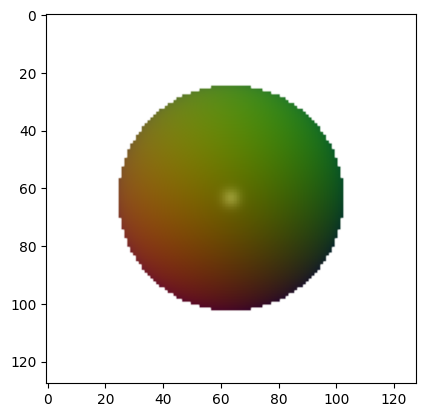

In [ ]:
image = renderer(sphere_mesh, cameras=cameras, lights=lights)
plt.imshow(image[0, ..., :].detach().cpu().numpy())

# Create a basic ML model

In [9]:
class RotationPredictor(nn.Module):
    def __init__(self):
        super(RotationPredictor, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.contiguous().view(-1, 128 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Helper functions
We also need some helper functions for rotating and visualizing the spheres while training.

In [10]:
def create_rotated_sphere(sphere_mesh, angle_degrees, device):
  angle = torch.tensor([angle_degrees * np.pi / 180.0], device=device)

  rot_y = torch.tensor([[torch.cos(angle), 0, torch.sin(angle)],
                        [0, 1, 0],
                        [-torch.sin(angle), 0, torch.cos(angle)]], device=device)

  rotated_verts = sphere_mesh.verts_packed() @ rot_y.T

  rotated_mesh = Meshes(
    verts=[rotated_verts],
    faces=[sphere_mesh.faces_packed()],
    textures=sphere_mesh.textures
  )

  return rotated_mesh

In [11]:
def visualize_sphere(sphere_mesh, vertex_colors, renderer, cameras, lights):
  with torch.no_grad():
    num_verts = sphere_mesh.verts_packed().shape[0]

    vertex_colors_vis = vertex_colors.clone().detach()
    vertex_colors_vis = vertex_colors_vis.reshape(1, num_verts, 3)

    textures = TexturesVertex(verts_features=vertex_colors_vis)

    vis_mesh = Meshes(
        verts=[sphere_mesh.verts_packed()],
        faces=[sphere_mesh.faces_packed()],
        textures=textures
    )

    image = renderer(vis_mesh, cameras=cameras, lights=lights)
    plt.figure(figsize=(5, 5))
    plt.imshow(image[0, ..., :3].cpu().numpy())
    plt.axis('off')
    plt.show()


## Train and test loops

In [12]:
def angle_difference_degrees(pred_angle, target_angle):
  diff = abs(target_angle - pred_angle)
  diff = (diff + 180) % 360 - 180
  return abs(diff)

def angle_difference_radians(pred_angle, target_angle):
  diff = abs(target_angle - pred_angle)
  diff = (diff + np.pi) % (2 * np.pi) - np.pi
  return abs(diff)

In [13]:
def angle_loss(pred_angles, target_angles):
    diff = torch.abs(pred_angles - target_angles)
    loss = torch.remainder(diff + np.pi, 2 * np.pi) - np.pi
    return torch.mean(torch.abs(loss))

In [48]:
def train_model(model, optimizer, mesh, vertex_colors, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=angle_loss):
  losses = []
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    total_loss = 0

    batch_images = []
    batch_target_angles = []

    for i in range(batch_size):

      textures = TexturesVertex(verts_features=vertex_colors.clone())
      mesh.textures = textures
      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      batch_images.append(image)
      batch_target_angles.append(target_angle)

    batch_images = torch.cat(batch_images, dim=0)
    batch_target_angles = torch.cat(batch_target_angles, dim=0)

    batch_pred_angles = model(batch_images)

    loss = criterion(batch_pred_angles, batch_target_angles)

    loss.backward()

    optimizer.step()

    losses.append(loss.detach().cpu().numpy())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")
        visualize_sphere(mesh, vertex_colors, renderer, cameras, lights)

  return losses

In [15]:
def test_model(model, sphere_mesh, renderer, cameras, lights, num_tests=500):
  total_error = 0
  with torch.no_grad():
    for i in range(num_tests):
      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(sphere_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)

      predicted_angle_degrees = predicted_angle.item() * 180 / np.pi

      # print("Angle:", angle, "Predicted angle:", predicted_angle_degrees, "Error:", angle_difference_degrees(predicted_angle_degrees, angle))
      total_error += angle_difference_degrees(predicted_angle_degrees, angle)

  me = total_error / num_tests
  return me


# Experiments

## Color optimization

### Optimizing only the weights (baseline)

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()
verts_min = verts.min(dim=0, keepdim=True)[0]
verts_max = verts.max(dim=0, keepdim=True)[0]
normalized_verts = (verts - verts_min) / (verts_max - verts_min)

vertex_colors = nn.Parameter(normalized_verts.unsqueeze(0))
textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 0.9354


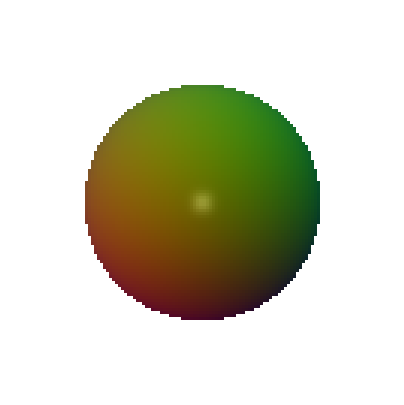

Epoch [200/1000], Loss: 0.5331


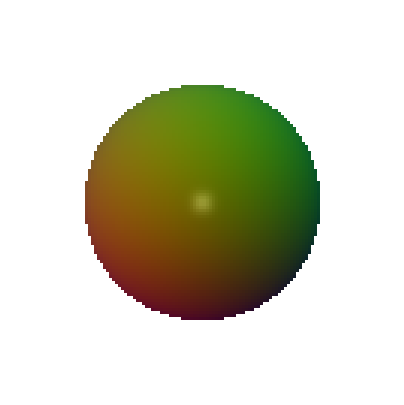

Epoch [300/1000], Loss: 0.3630


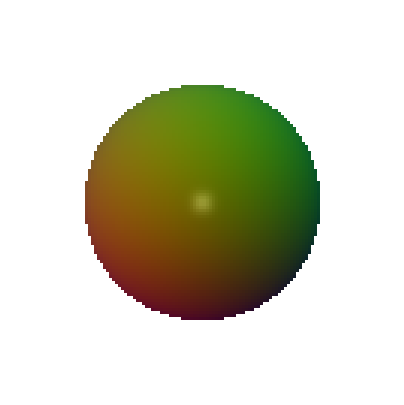

Epoch [400/1000], Loss: 0.2779


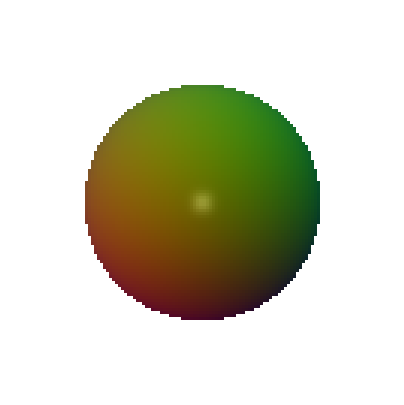

Epoch [500/1000], Loss: 0.1456


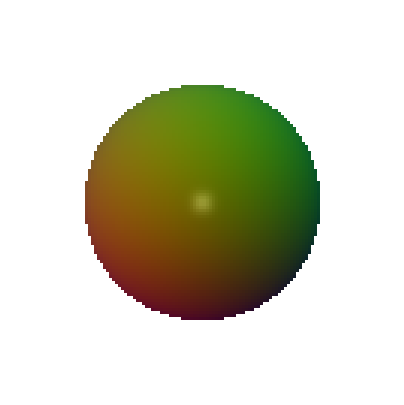

Epoch [600/1000], Loss: 0.0957


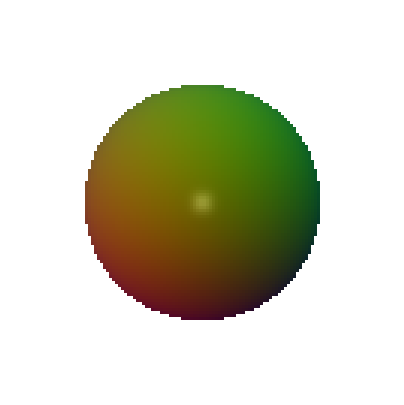

Epoch [700/1000], Loss: 0.2333


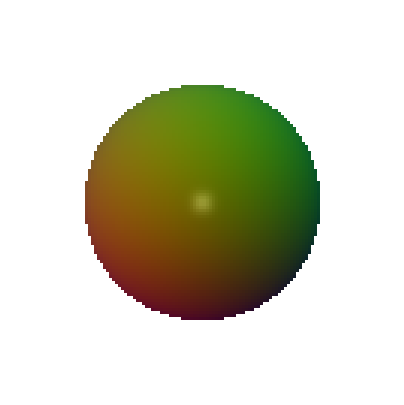

Epoch [800/1000], Loss: 0.0704


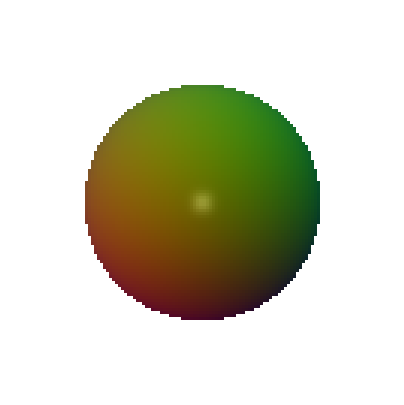

Epoch [900/1000], Loss: 0.2255


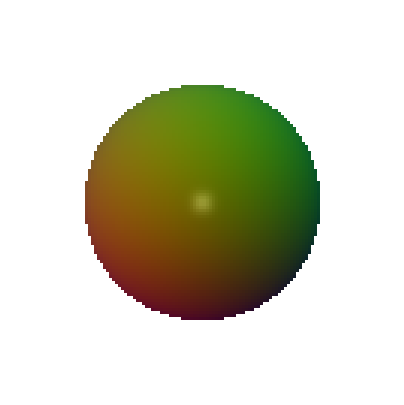

Epoch [1000/1000], Loss: 0.1086


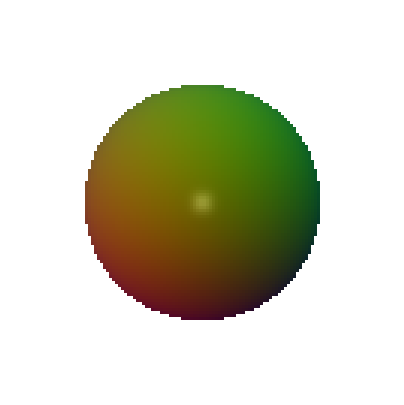

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=1000, batch_size=16)

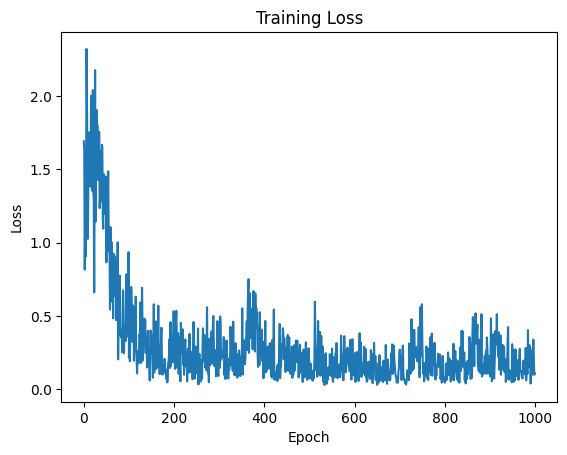

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
me = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 9.11 (degrees).


### Optimizing the colors and the weights simultaneously
The vertex colors were declared as a neural network parameter (nn.Parameter), so they will be learned during training.

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()
verts_min = verts.min(dim=0, keepdim=True)[0]
verts_max = verts.max(dim=0, keepdim=True)[0]
normalized_verts = (verts - verts_min) / (verts_max - verts_min)

vertex_colors = nn.Parameter(normalized_verts.unsqueeze(0))
textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 0.4181


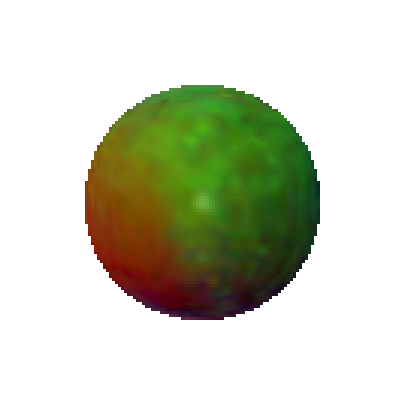

Epoch [200/1000], Loss: 0.1709


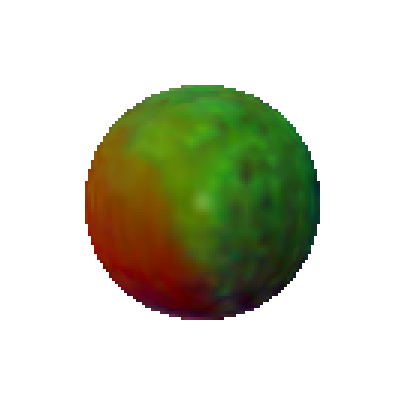

Epoch [300/1000], Loss: 0.1316


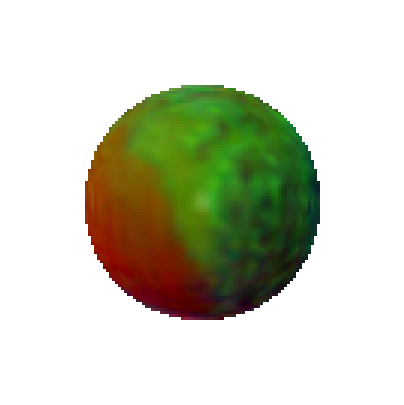

Epoch [400/1000], Loss: 0.0594


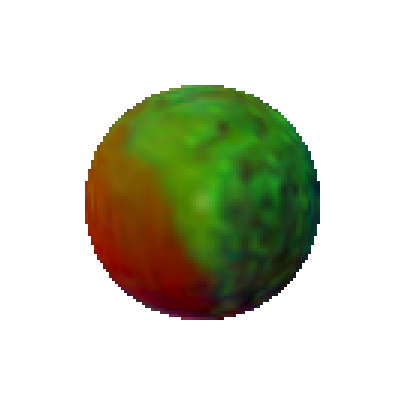

Epoch [500/1000], Loss: 0.1025


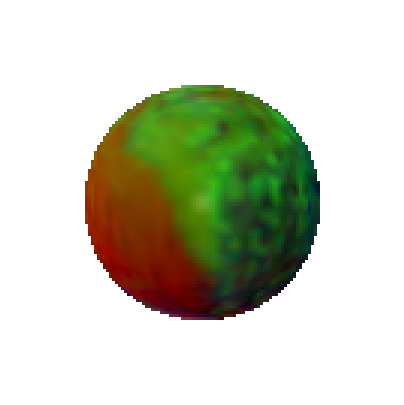

Epoch [600/1000], Loss: 0.0446


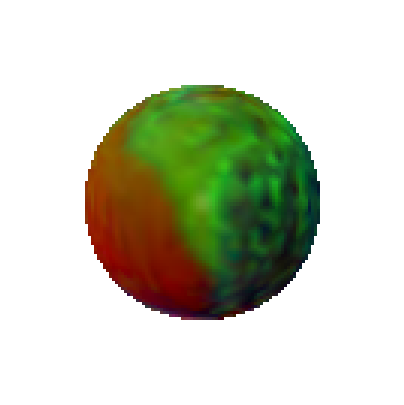

Epoch [700/1000], Loss: 0.0258


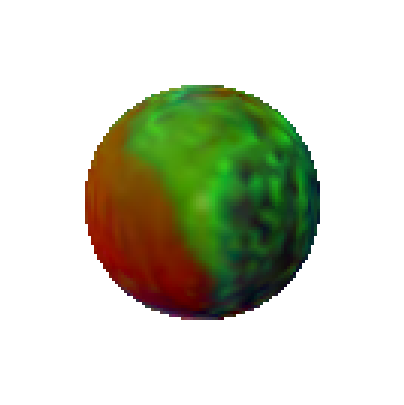

Epoch [800/1000], Loss: 0.0562


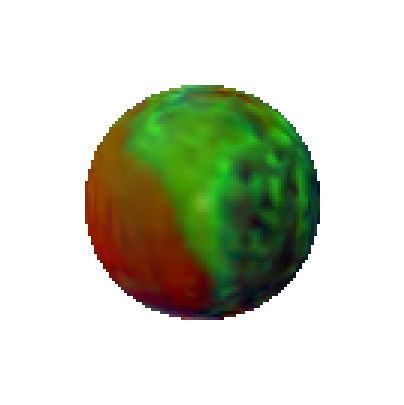

Epoch [900/1000], Loss: 0.0611


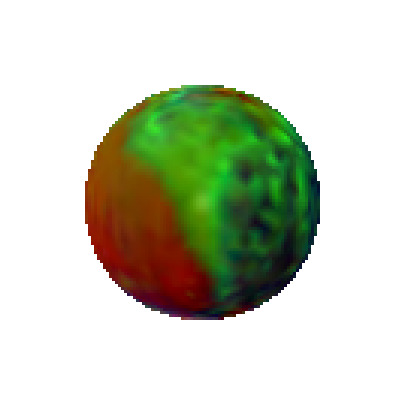

Epoch [1000/1000], Loss: 0.0833


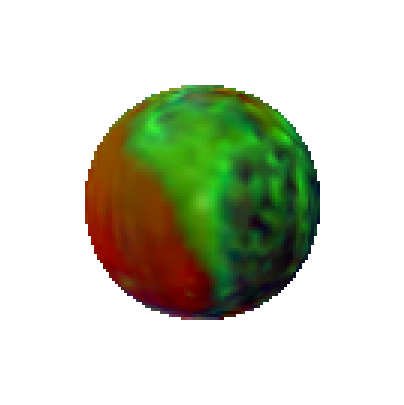

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=1000, batch_size=16)

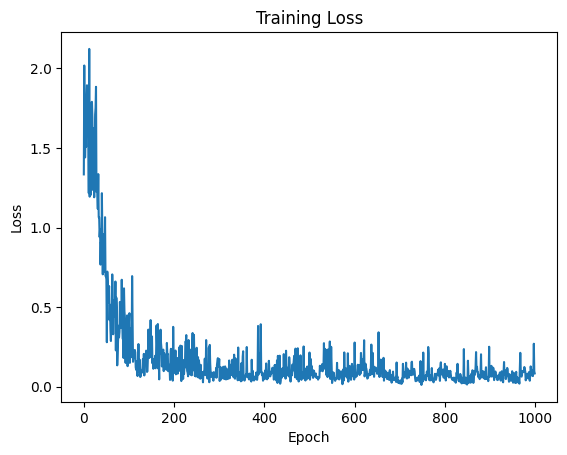

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
me = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests=10)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Angle: 279 Predicted angle: -74.77103707061339 Error: 6.2289629293866255
Angle: 159 Predicted angle: -197.55572219491015 Error: 3.4442778050898823
Angle: 67 Predicted angle: 75.43855828838791 Error: 8.438558288387924
Angle: 66 Predicted angle: 74.42794300822531 Error: 8.427943008225327
Angle: 155 Predicted angle: -194.04342035763617 Error: 10.956579642363863
Angle: 156 Predicted angle: -195.67388213516656 Error: 8.326117864833463
Angle: 75 Predicted angle: 84.63540800581008 Error: 9.635408005810064
Angle: 140 Predicted angle: 141.4859206567101 Error: 1.4859206567101069
Angle: 259 Predicted angle: -96.3188290717104 Error: 4.681170928289589
Angle: 207 Predicted angle: -154.8246653887197 Error: 1.8246653887197226
Mean error over 500 tests: 6.34 (degrees).


## Color optimization (monochrome initial color)

### Optimizing only the weights

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.expand(verts.shape)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.8974


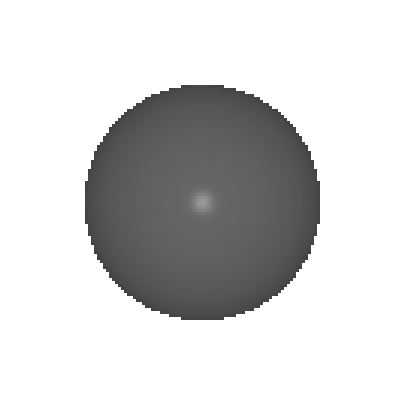

Epoch [200/1000], Loss: 1.8257


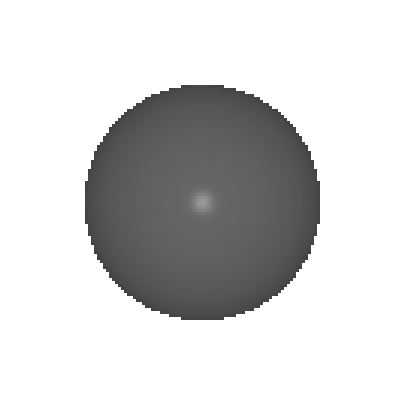

Epoch [300/1000], Loss: 2.1792


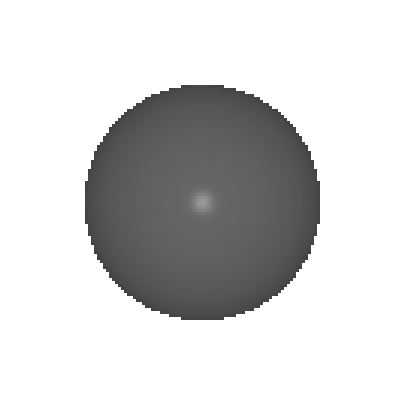

Epoch [400/1000], Loss: 1.6249


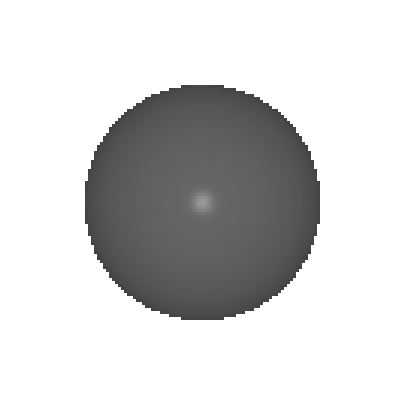

Epoch [500/1000], Loss: 1.0446


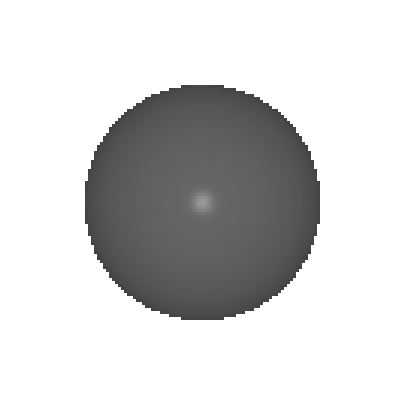

Epoch [600/1000], Loss: 1.6548


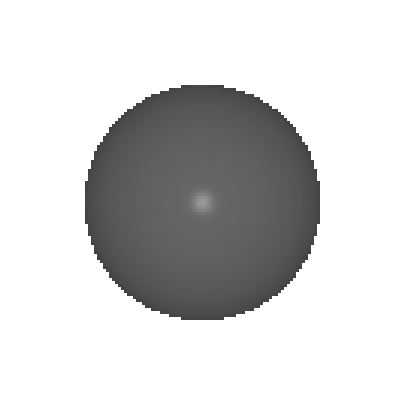

Epoch [700/1000], Loss: 1.4408


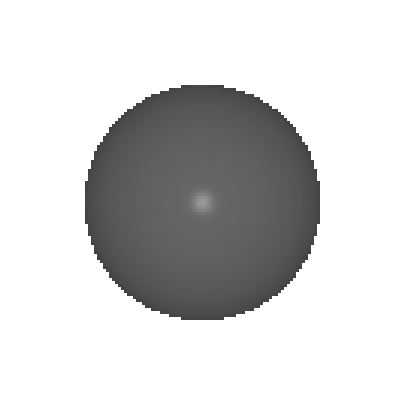

Epoch [800/1000], Loss: 1.2515


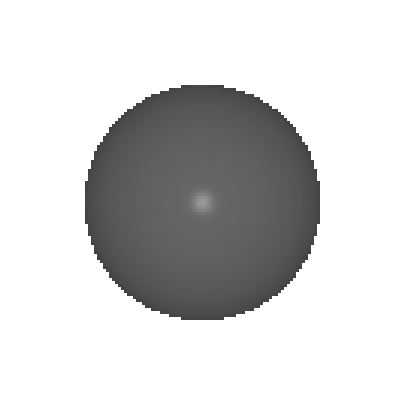

Epoch [900/1000], Loss: 1.6231


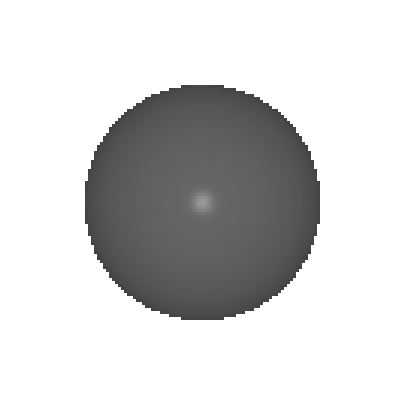

Epoch [1000/1000], Loss: 1.6085


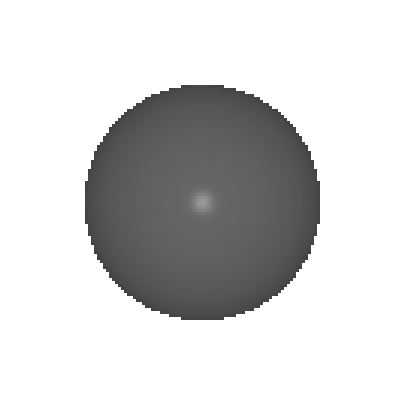

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=1000, batch_size=16)

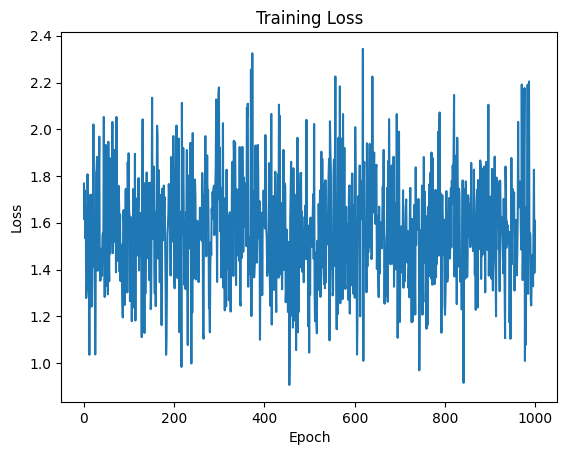

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
me = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests)
print(f"Mean squared over {num_tests} tests: {me:.2f} (degrees).")

Root mean squared error over 500 tests: 87.65 (degrees).


### Optimizing the colors and the weights simultaneously
The vertex colors were declared as a neural network parameter (nn.Parameter), so they will be learned during training.

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.6565


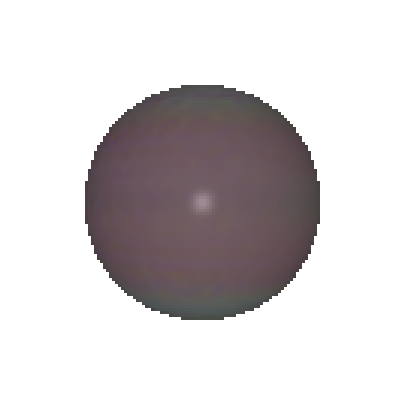

Epoch [200/1000], Loss: 0.3547


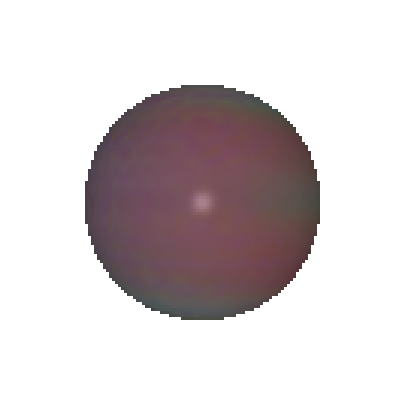

Epoch [300/1000], Loss: 0.0978


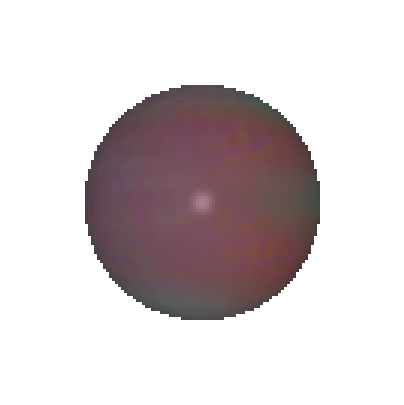

Epoch [400/1000], Loss: 0.1241


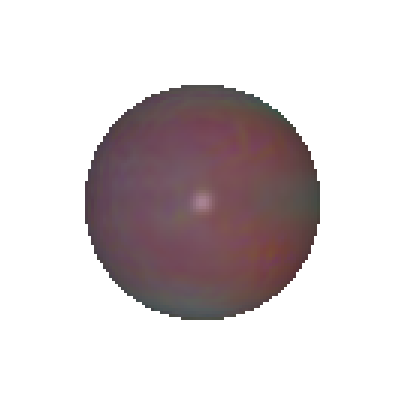

Epoch [500/1000], Loss: 0.1674


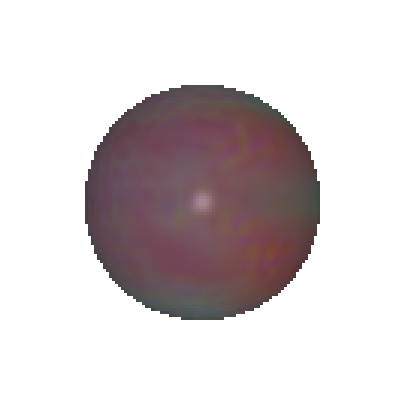

Epoch [600/1000], Loss: 0.1627


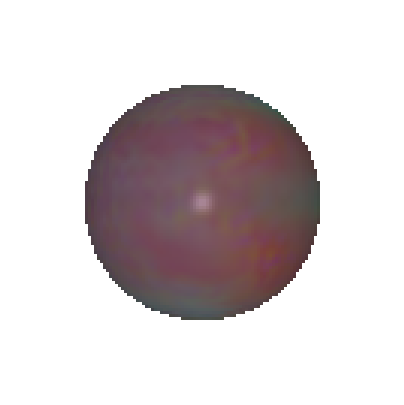

Epoch [700/1000], Loss: 0.1342


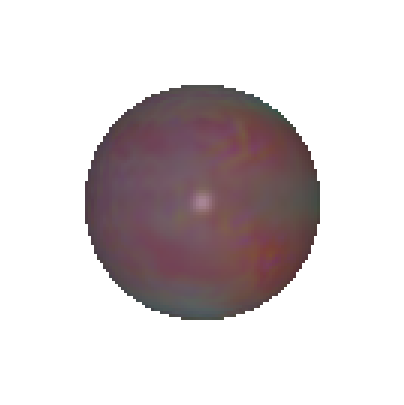

Epoch [800/1000], Loss: 0.0578


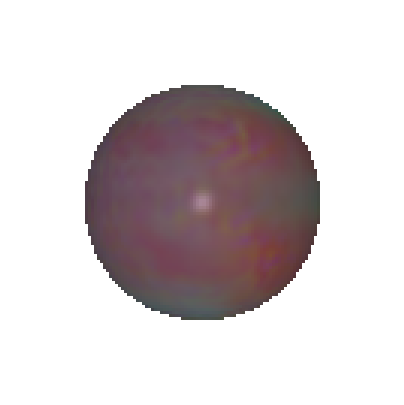

Epoch [900/1000], Loss: 0.0323


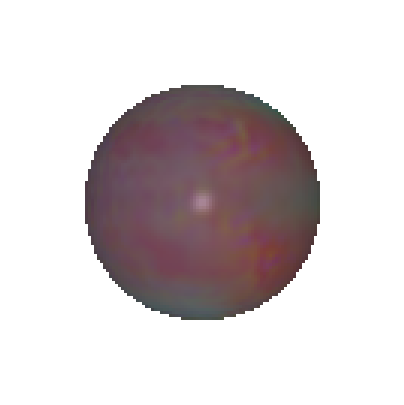

Epoch [1000/1000], Loss: 0.0246


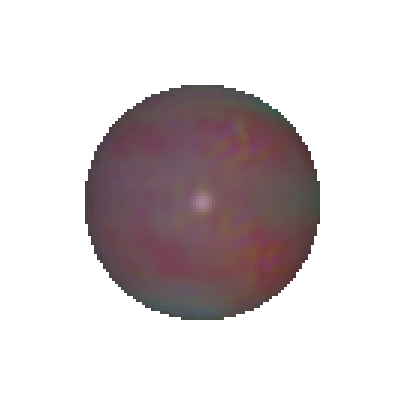

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, renderer, cameras, lights, num_epochs=1000, batch_size=16)

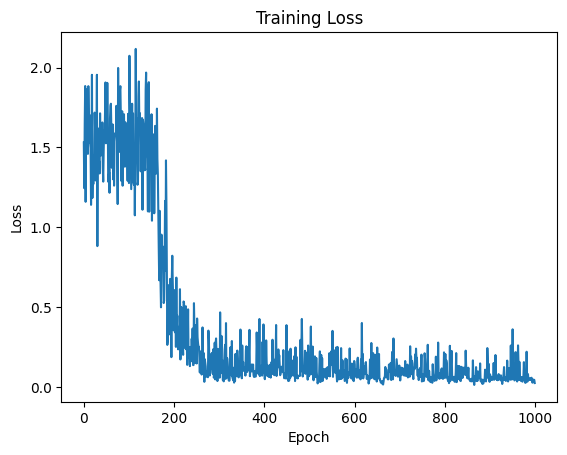

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
num_tests=500
me = test_model(model, sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Root mean squared error over 500 tests: 3.36 (degrees).


## Shape optimization

In [ ]:
def train_model(model, optimizer, mesh, deform_verts, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=angle_loss, use_smoothing_loss=False, smoothing_weight=1):
  losses = []
  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      deformed_mesh = mesh.clone().offset_verts(deform_verts)

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      if use_smoothing_loss:
          loss += smoothing_weight * mesh_laplacian_smoothing(deformed_mesh, method="uniform")
          loss += smoothing_weight * mesh_normal_consistency(deformed_mesh)
          loss += smoothing_weight * mesh_edge_loss(deformed_mesh)

      total_loss += loss

    total_loss.backward()
    optimizer.step()

    avg_epoch_loss = total_loss.item() / batch_size
    losses.append(avg_epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        deformed_mesh = mesh.clone().offset_verts(deform_verts)
        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

### Optimizing the shape and the weights simultaneously

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.8984


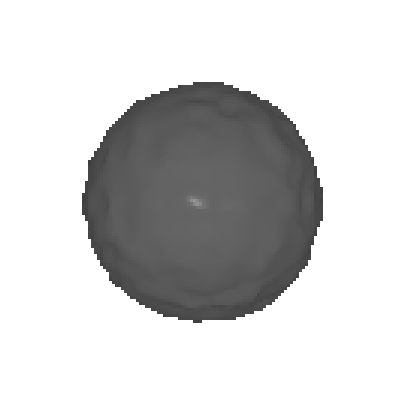

Epoch [200/1000], Loss: 1.3066


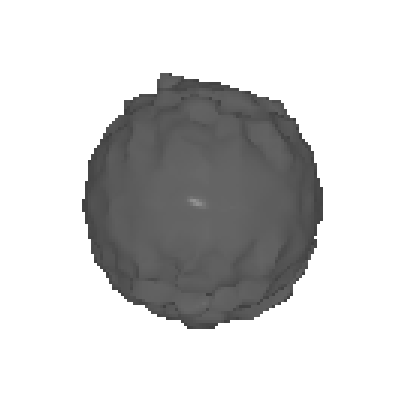

Epoch [300/1000], Loss: 0.3611


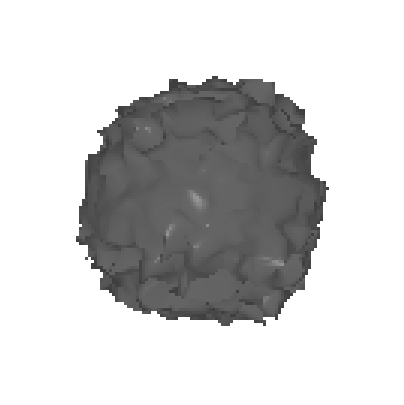

Epoch [400/1000], Loss: 0.2752


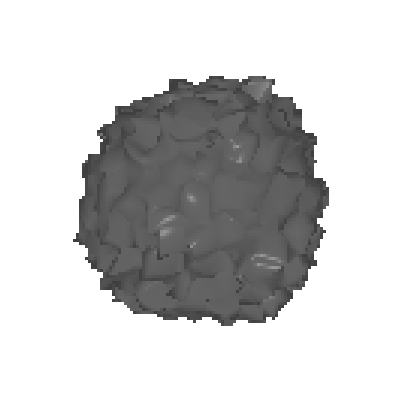

Epoch [500/1000], Loss: 0.1963


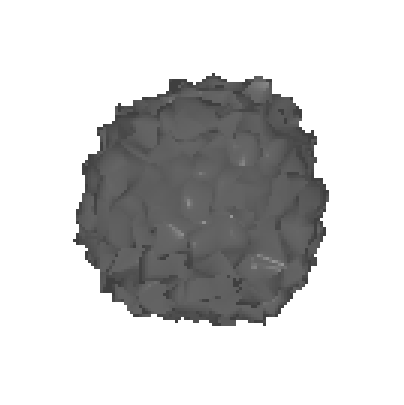

Epoch [600/1000], Loss: 0.0986


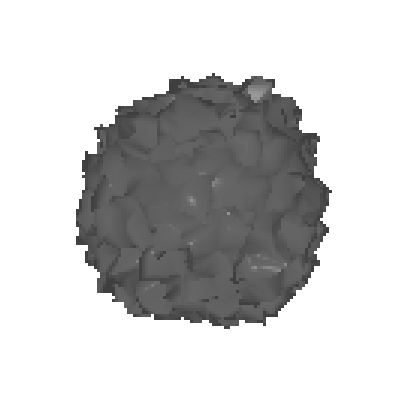

Epoch [700/1000], Loss: 0.1625


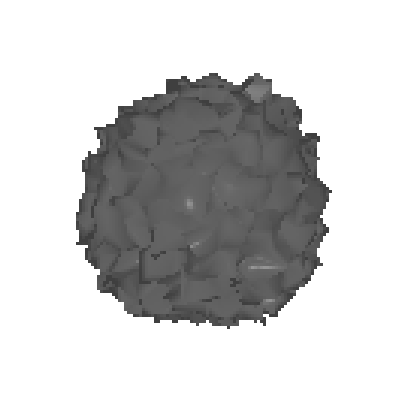

Epoch [800/1000], Loss: 0.1211


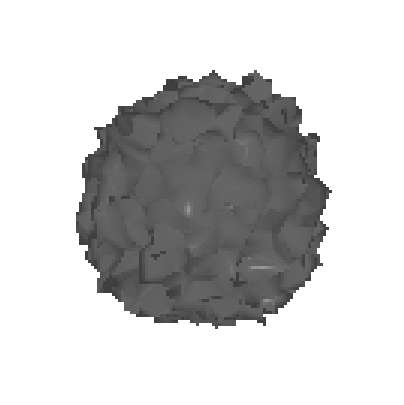

Epoch [900/1000], Loss: 0.0748


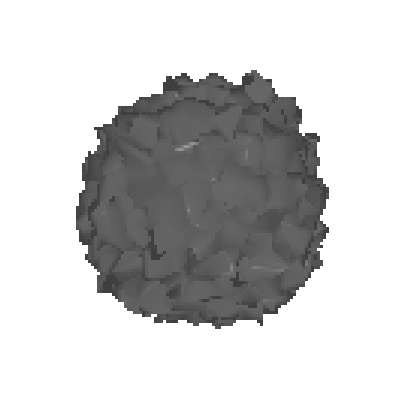

Epoch [1000/1000], Loss: 0.1088


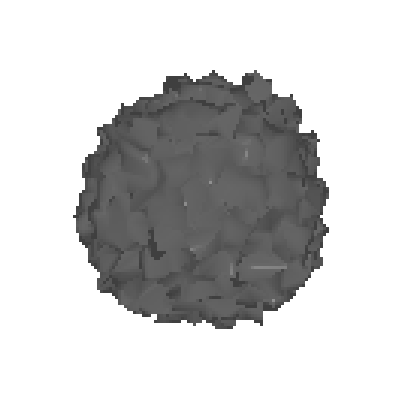

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16)

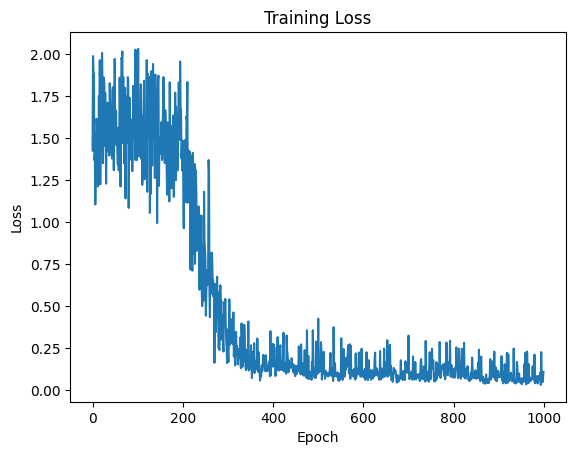

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
me = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 5.65 (degrees).


### Optimizing the shape and the weights simultaneously with smoothing (smoothing_weight = 1)

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.7634


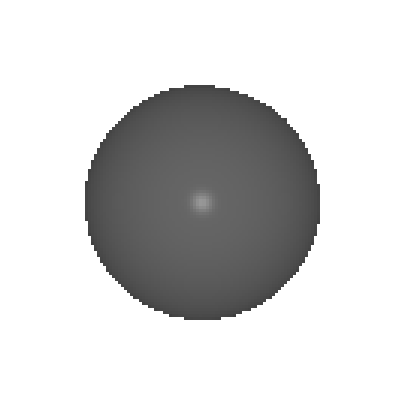

Epoch [200/1000], Loss: 1.3734


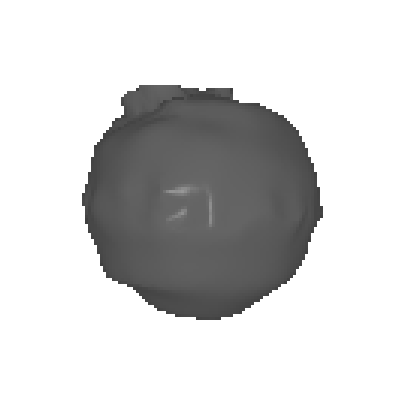

Epoch [300/1000], Loss: 0.2100


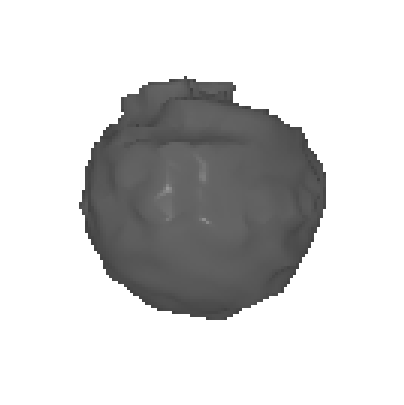

Epoch [400/1000], Loss: 0.1795


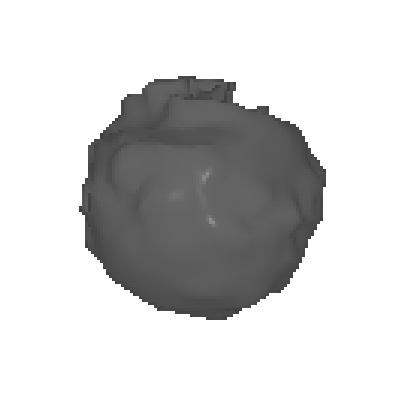

Epoch [500/1000], Loss: 0.1490


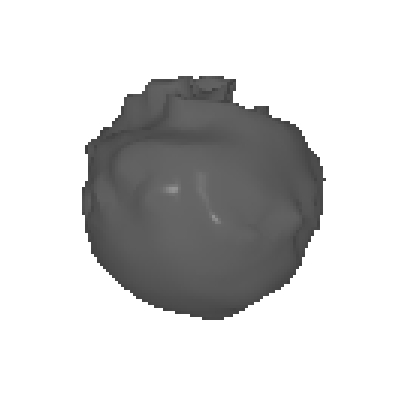

Epoch [600/1000], Loss: 0.1766


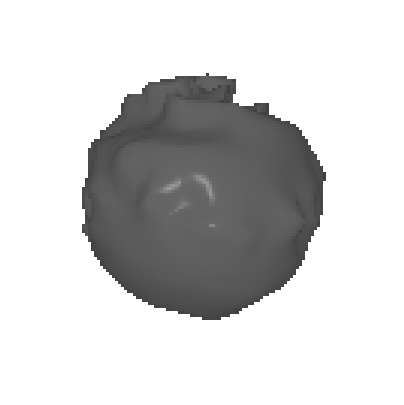

Epoch [700/1000], Loss: 0.1670


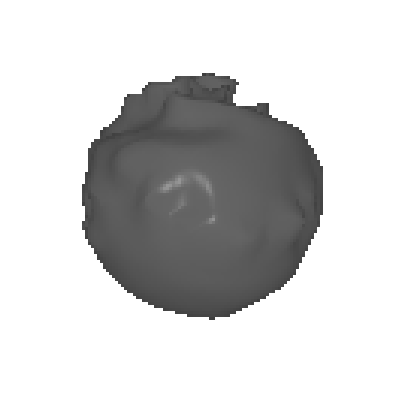

Epoch [800/1000], Loss: 0.0867


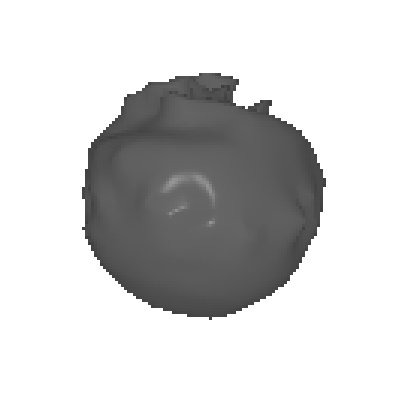

Epoch [900/1000], Loss: 0.2709


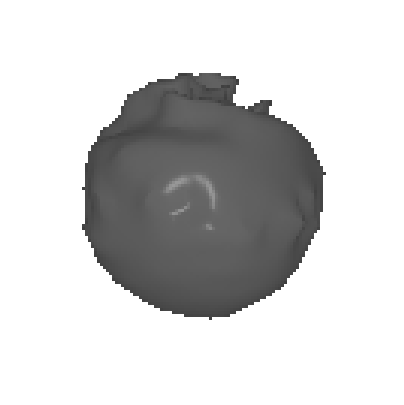

Epoch [1000/1000], Loss: 0.0747


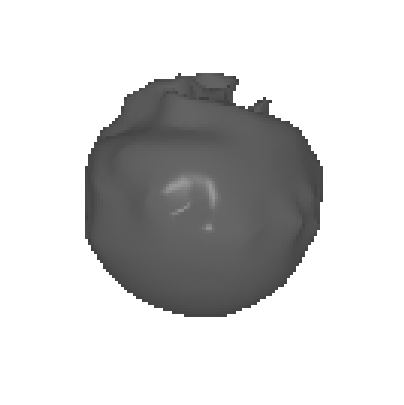

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16, use_smoothing_loss=True)

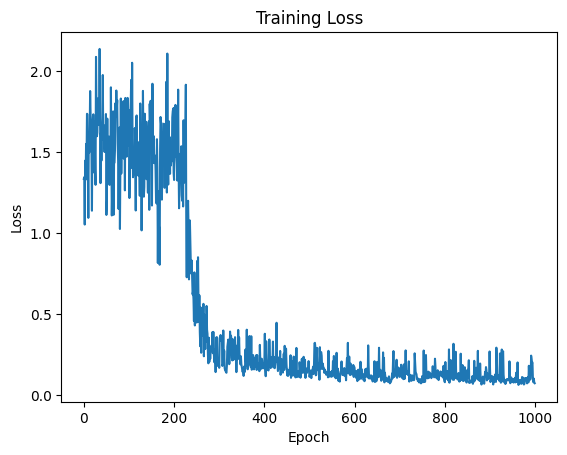

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
me = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 5.04 (degrees).


### Optimizing the shape and the weights simultaneously with smoothing (smoothing_weight = 1.25)

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.5641


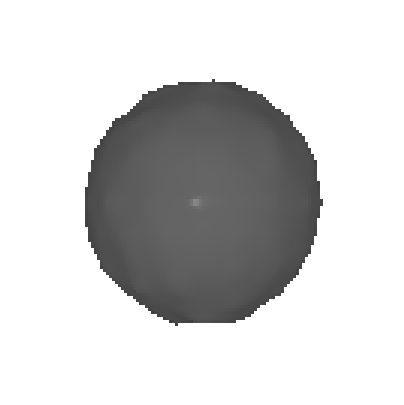

Epoch [200/1000], Loss: 0.4025


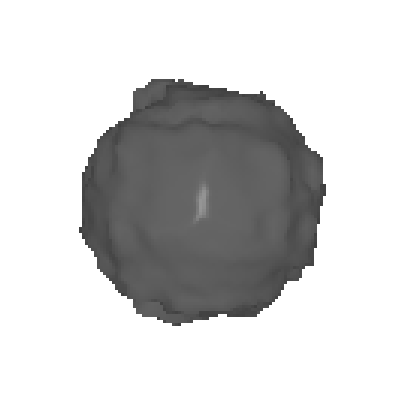

Epoch [300/1000], Loss: 0.1277


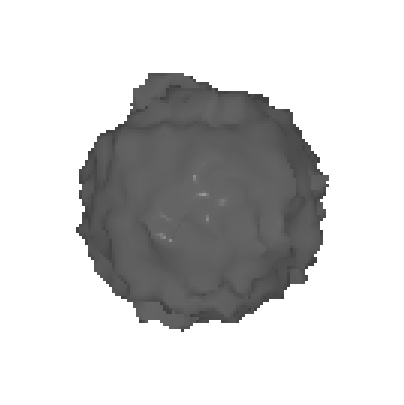

Epoch [400/1000], Loss: 0.1371


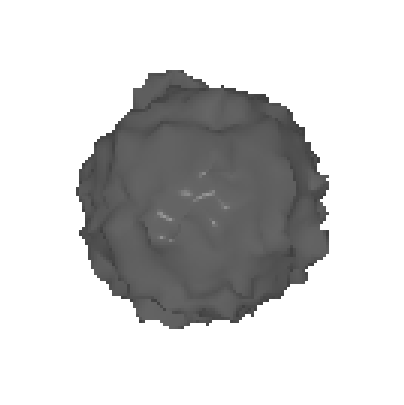

Epoch [500/1000], Loss: 0.2299


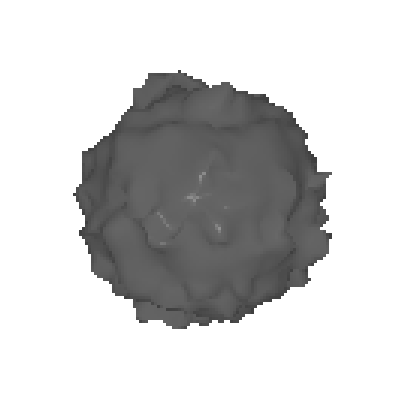

Epoch [600/1000], Loss: 0.0840


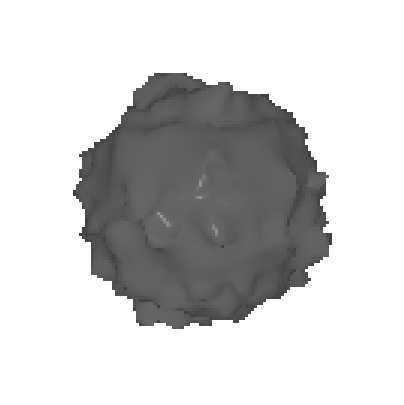

Epoch [700/1000], Loss: 0.1192


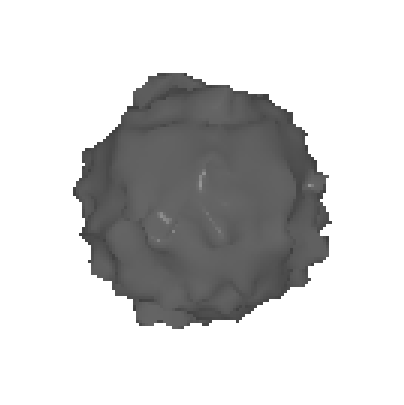

Epoch [800/1000], Loss: 0.0942


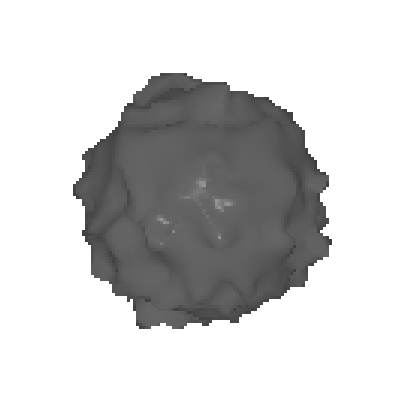

Epoch [900/1000], Loss: 0.0694


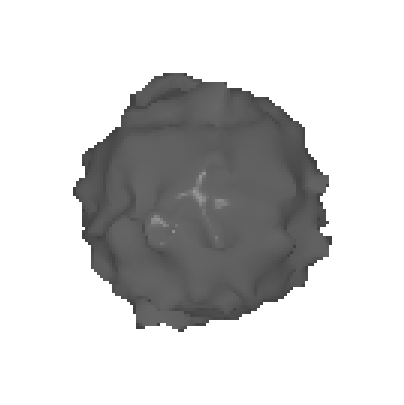

Epoch [1000/1000], Loss: 0.0776


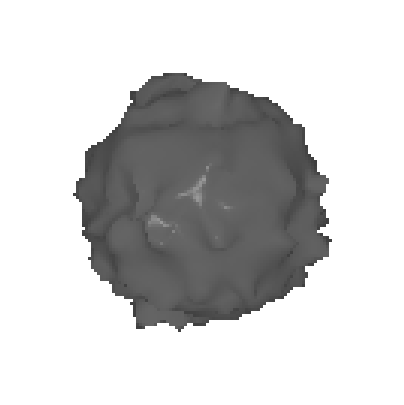

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16, use_smoothing_loss=True, smoothing_weight=1.25)

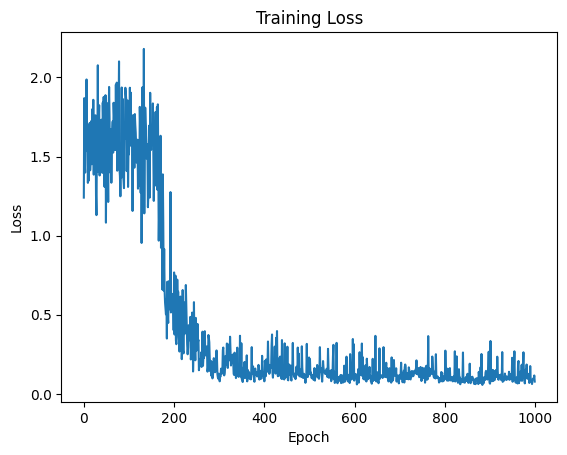

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
me = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 3.91 (degrees).


### Optimizing the shape and the weights simultaneously with smoothing (smoothing_weight = 1.5)

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.2180


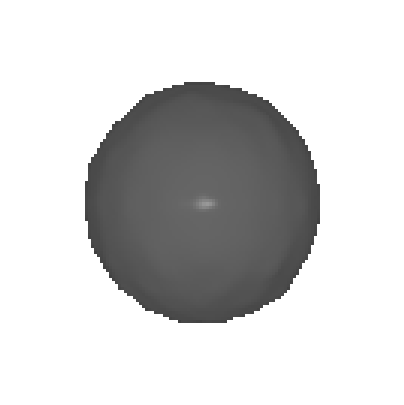

Epoch [200/1000], Loss: 1.4394


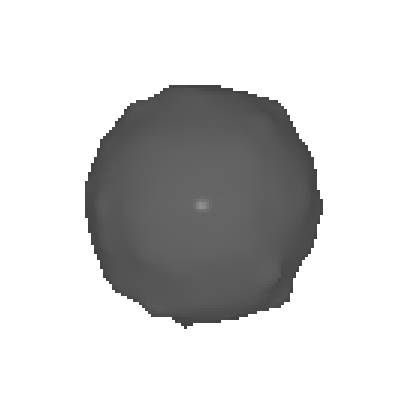

Epoch [300/1000], Loss: 0.4918


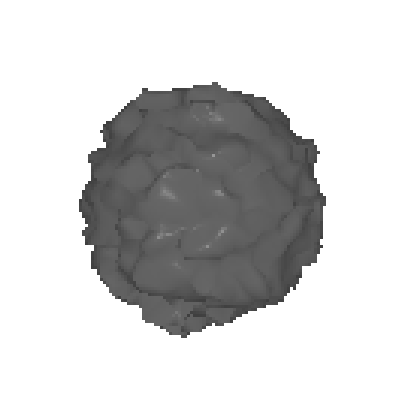

Epoch [400/1000], Loss: 0.2574


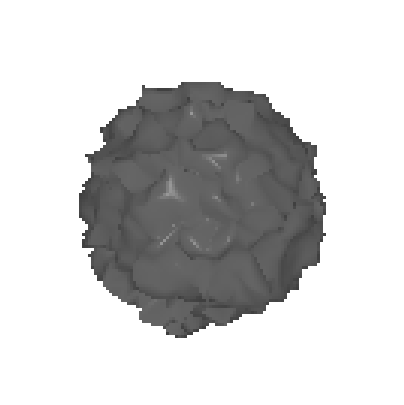

Epoch [500/1000], Loss: 0.1830


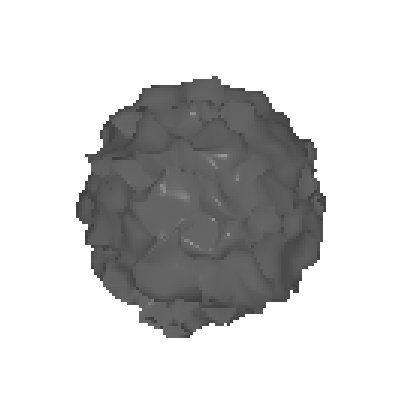

Epoch [600/1000], Loss: 0.1110


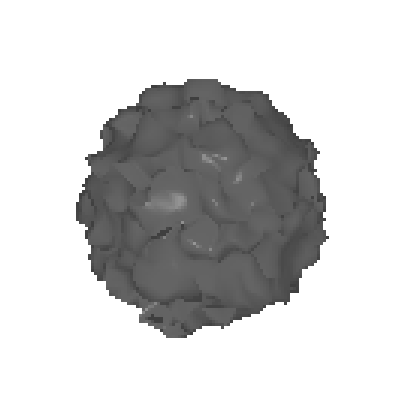

Epoch [700/1000], Loss: 0.1553


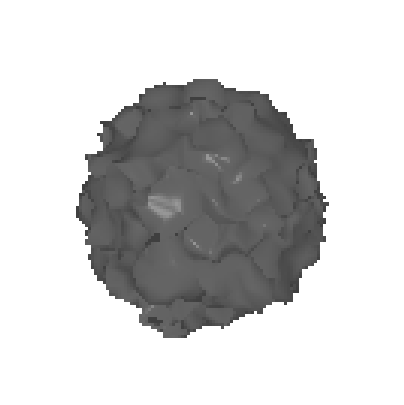

Epoch [800/1000], Loss: 0.1244


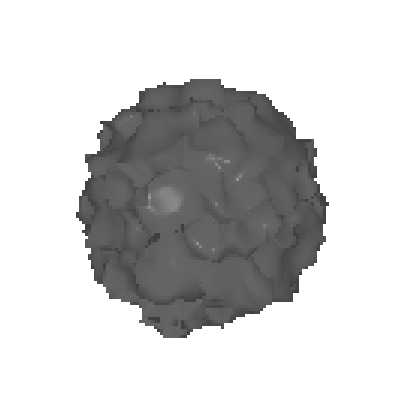

Epoch [900/1000], Loss: 0.2577


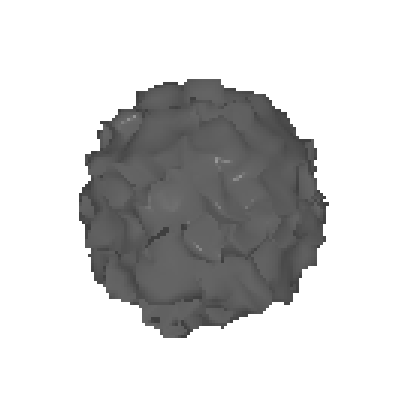

Epoch [1000/1000], Loss: 0.2936


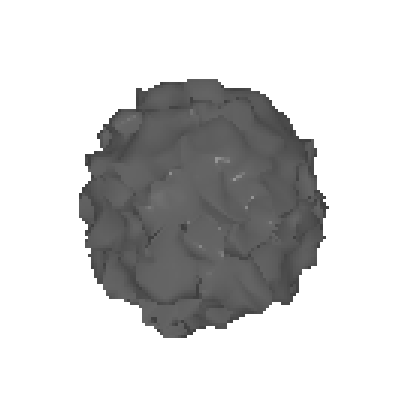

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16, use_smoothing_loss=True, smoothing_weight=1.5)

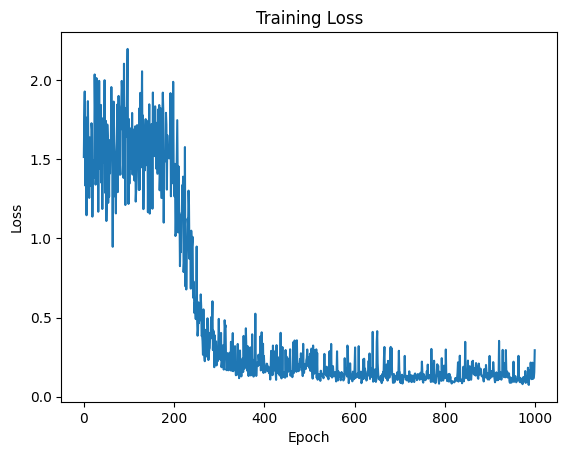

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
me = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 3.39 (degrees).


## Color and shape optimization

In [ ]:
def train_model(model, optimizer, mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=angle_loss, use_smoothing_loss=False, smoothing_weight=1):
  losses = []
  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      deformed_mesh = mesh.clone().offset_verts(deform_verts)

      textures = TexturesVertex(verts_features=vertex_colors.clone())
      deformed_mesh.textures = textures

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      if use_smoothing_loss:
          loss += mesh_laplacian_smoothing(deformed_mesh, method="uniform") * smoothing_weight

      total_loss += loss

    total_loss.backward()
    optimizer.step()

    avg_epoch_loss = total_loss.item() / batch_size
    losses.append(avg_epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        deformed_mesh = mesh.clone().offset_verts(deform_verts)
        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

### Optimizing the colors, shape and weights simultaneously

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.5128


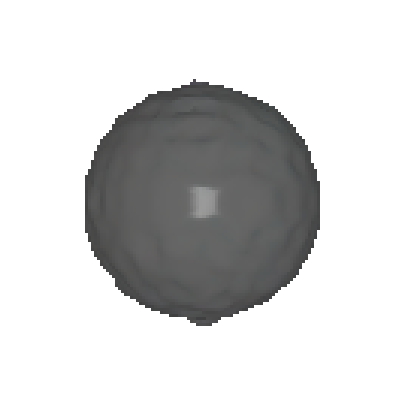

Epoch [200/1000], Loss: 0.1803


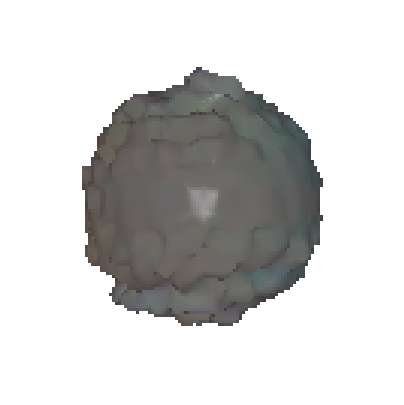

Epoch [300/1000], Loss: 0.1410


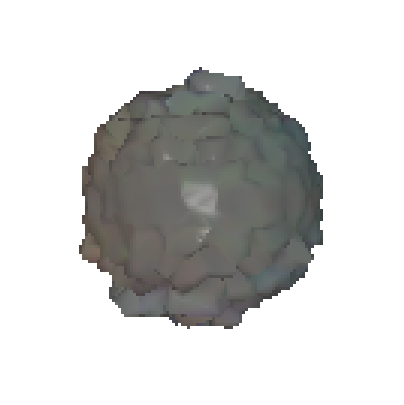

Epoch [400/1000], Loss: 0.0469


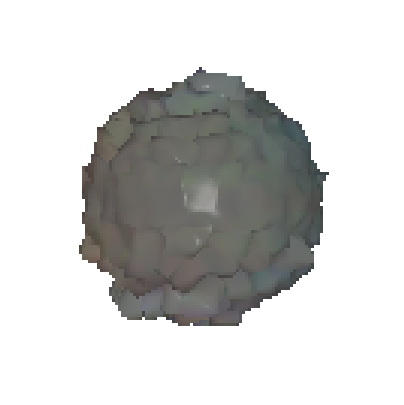

Epoch [500/1000], Loss: 0.0847


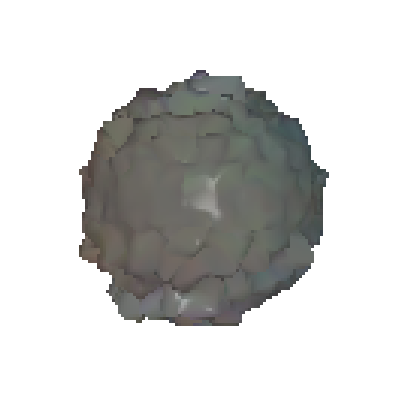

Epoch [600/1000], Loss: 0.0752


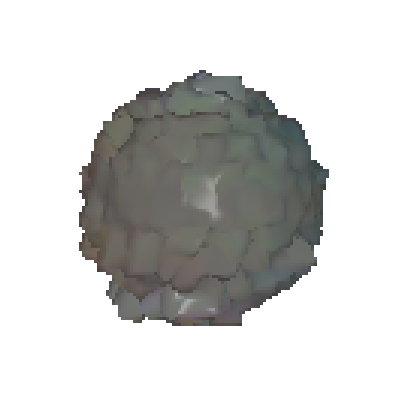

Epoch [700/1000], Loss: 0.0266


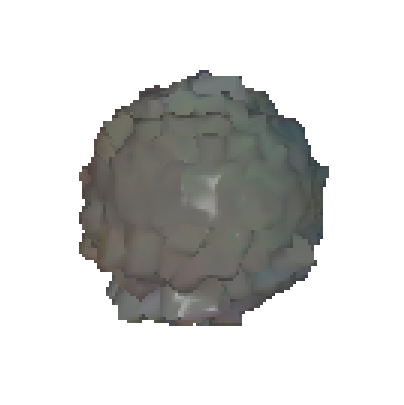

Epoch [800/1000], Loss: 0.0407


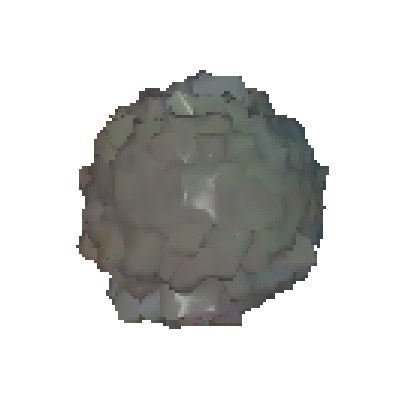

Epoch [900/1000], Loss: 0.0473


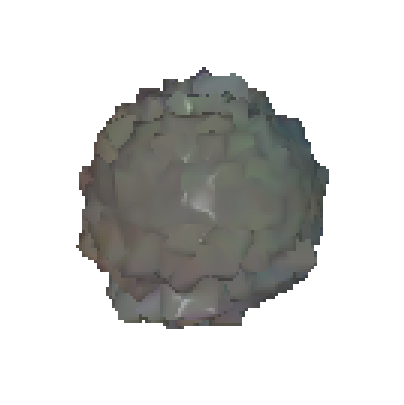

Epoch [1000/1000], Loss: 0.0328


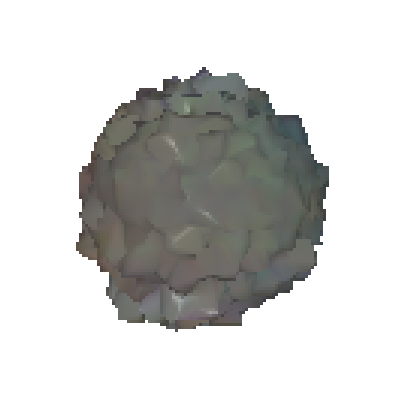

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16)

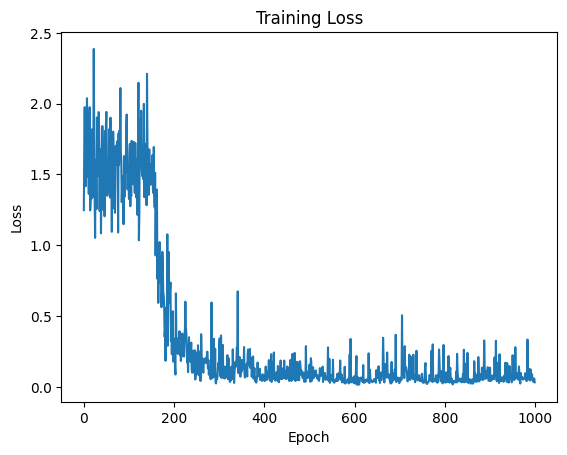

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
me = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Root mean squared error over 500 tests: 4.40 (degrees).


### Optimizing the colors, shape and weights simultaneously with smoothing

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 2.0806


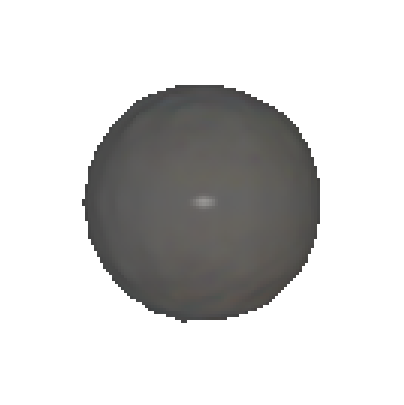

Epoch [200/1000], Loss: 1.6544


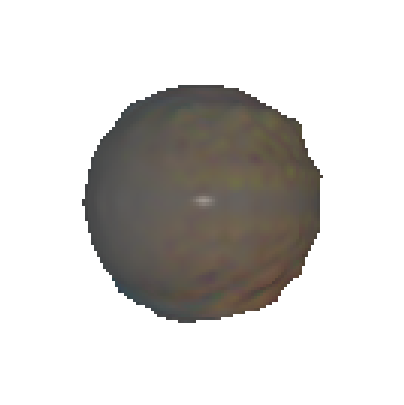

Epoch [300/1000], Loss: 0.3561


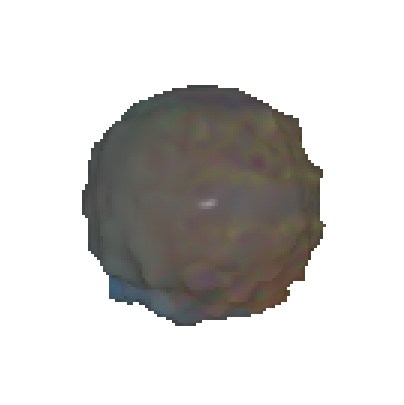

Epoch [400/1000], Loss: 0.1804


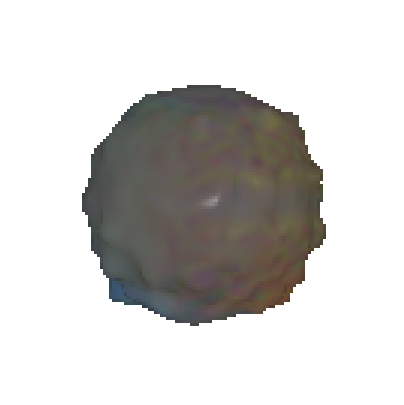

Epoch [500/1000], Loss: 0.0770


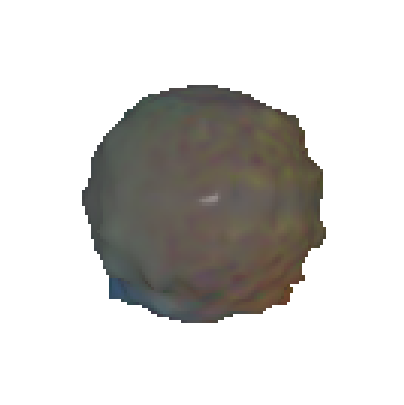

Epoch [600/1000], Loss: 0.0887


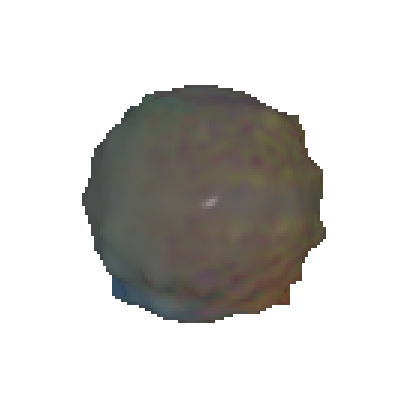

Epoch [700/1000], Loss: 0.1155


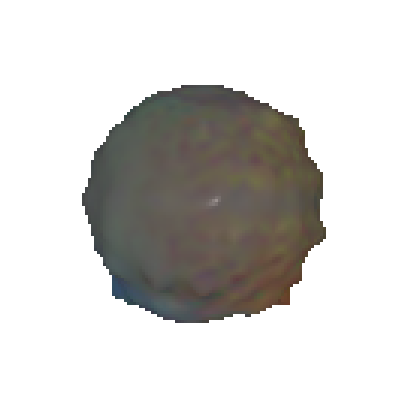

Epoch [800/1000], Loss: 0.0454


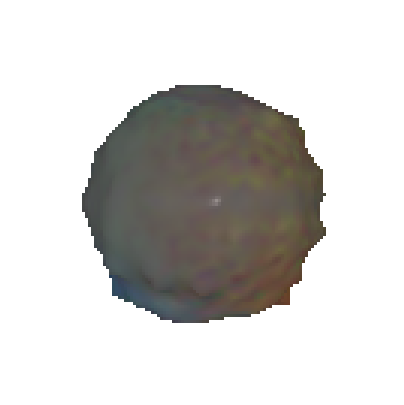

Epoch [900/1000], Loss: 0.0592


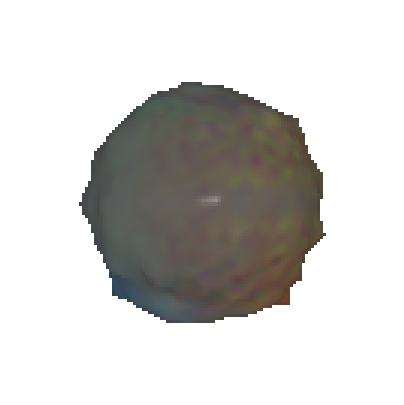

Epoch [1000/1000], Loss: 0.0932


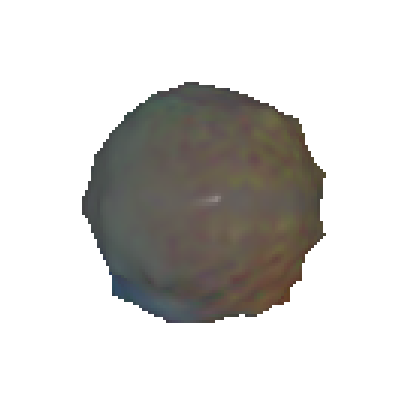

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16, use_smoothing_loss=True)

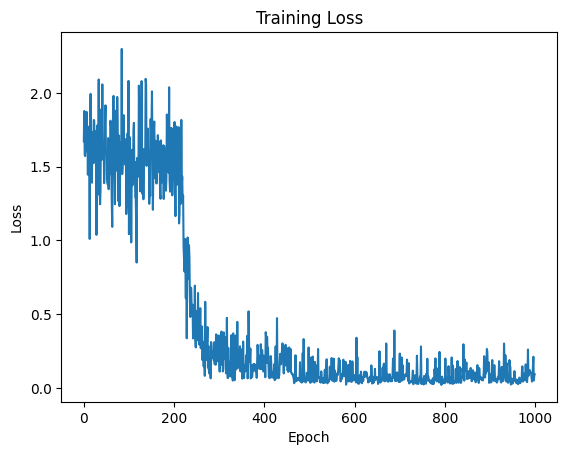

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

In [ ]:
num_tests=500
me = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 5.59 (degrees).


## Controlling deformations

### x-axis deform

In [ ]:
def train_model(model, optimizer, mesh, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=angle_loss, stretch_factor=None):
  losses = []

  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      verts = mesh.verts_packed()
      deformed_verts = torch.zeros_like(verts)

      if stretch_factor is not None:
        deformed_verts[:, 0] = verts[:, 0] * stretch_factor

      deformed_mesh = mesh.clone().offset_verts(deformed_verts)

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    avg_epoch_loss = total_loss / batch_size
    losses.append(avg_epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        print(f"Current stretch factor: {stretch_factor.item():.4f}")

        verts = mesh.verts_packed()
        deform_verts = torch.zeros_like(verts)
        deform_verts[:, 0] = verts[:, 0] * stretch_factor
        deformed_mesh = mesh.clone().offset_verts(deform_verts)

        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

In [ ]:
def test_model(model, sphere_mesh, renderer, cameras, lights, num_tests=500):
  total_error = 0
  with torch.no_grad():
    for i in range(num_tests):
      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(sphere_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)

      predicted_angle_degrees = predicted_angle.item() * 180 / np.pi

      # print("Angle:", angle, "Predicted angle:", predicted_angle_degrees, "Error:", angle_difference_degrees(predicted_angle_degrees, angle))
      total_error += angle_difference_degrees(predicted_angle_degrees, angle)

  me = total_error / num_tests
  return me


In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

stretch_factor = nn.Parameter(torch.tensor([0.1], device=device))

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [stretch_factor], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.1727
Current stretch factor: 0.1043


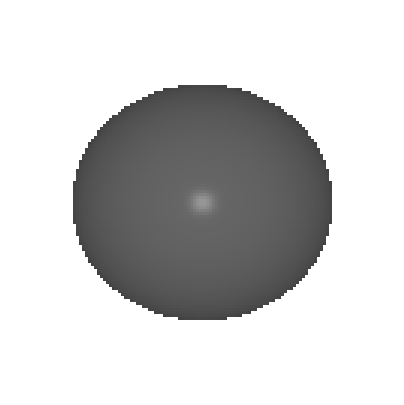

Epoch [200/1000], Loss: 1.4166
Current stretch factor: 0.1043


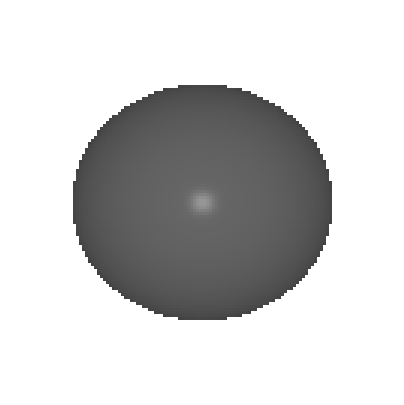

Epoch [300/1000], Loss: 1.2084
Current stretch factor: 0.1043


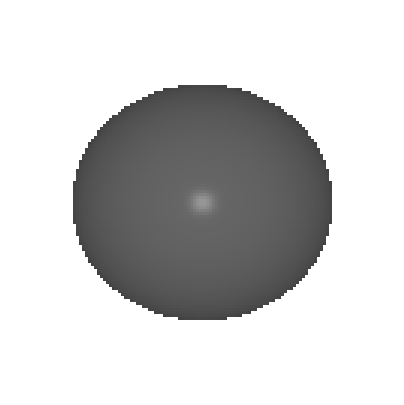

Epoch [400/1000], Loss: 1.6750
Current stretch factor: 0.1043


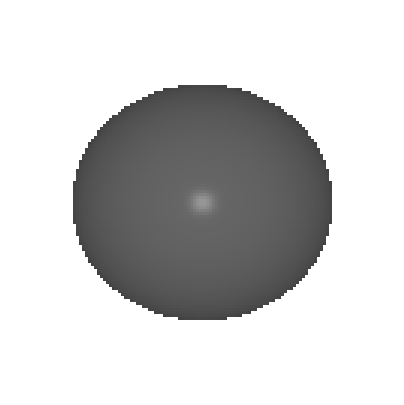

Epoch [500/1000], Loss: 1.3657
Current stretch factor: 0.1043


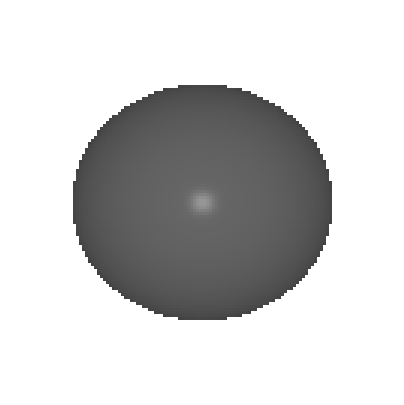

Epoch [600/1000], Loss: 1.6948
Current stretch factor: 0.1043


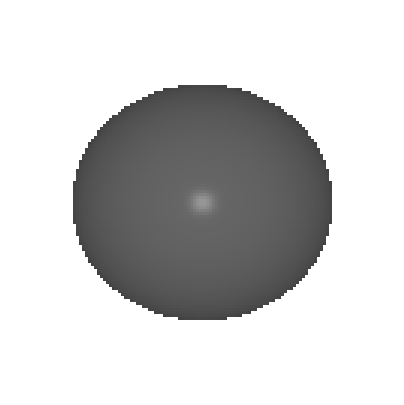

Epoch [700/1000], Loss: 1.6317
Current stretch factor: 0.1043


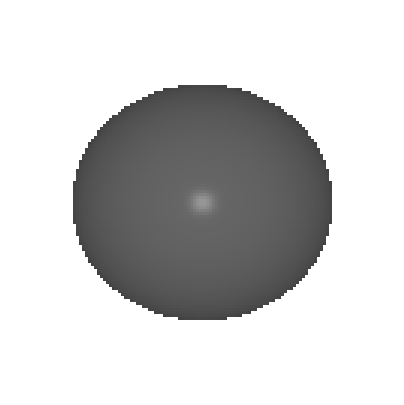

Epoch [800/1000], Loss: 1.4807
Current stretch factor: 0.1043


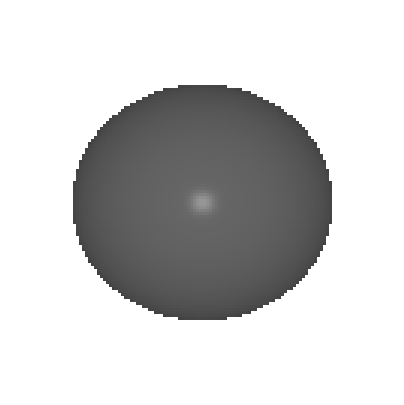

Epoch [900/1000], Loss: 1.7094
Current stretch factor: 0.1043


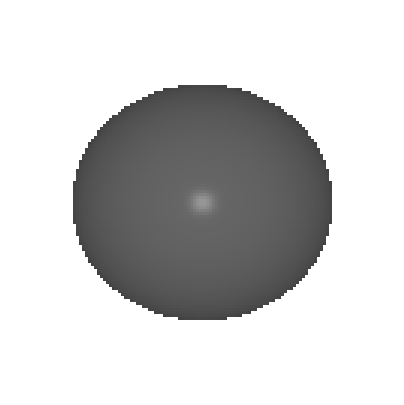

Epoch [1000/1000], Loss: 1.5321
Current stretch factor: 0.1043


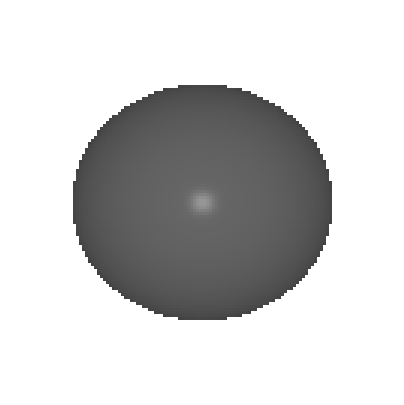

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, renderer, cameras, lights, num_epochs=1000, batch_size=16, stretch_factor=stretch_factor)

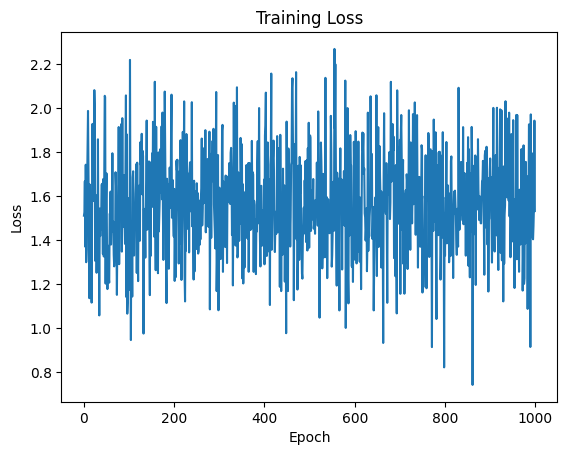

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

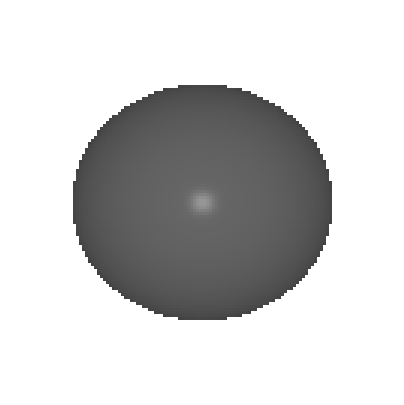

In [ ]:
verts = sphere_mesh.verts_packed()
deform_verts = torch.zeros_like(verts)
deform_verts[:, 0] = verts[:, 0] * stretch_factor
deformed_sphere_mesh = sphere_mesh.clone().offset_verts(deform_verts)

visualize_sphere(deformed_sphere_mesh, vertex_colors, renderer, cameras, lights)

In [ ]:
num_tests=500
me = test_model(model, deformed_sphere_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 89.20 (degrees).


### x-, y-, and z-axis deform

In [ ]:
def train_model(model, optimizer, mesh, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=angle_loss, stretch_factors=None):
  losses = []

  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      verts = mesh.verts_packed()
      deformed_verts = torch.zeros_like(verts)

      if stretch_factors is not None:
        deformed_verts[:, 0] = verts[:, 0] * stretch_factors[0]
        deformed_verts[:, 1] = verts[:, 1] * stretch_factors[1]
        deformed_verts[:, 2] = verts[:, 2] * stretch_factors[2]

      deformed_mesh = mesh.clone().offset_verts(deformed_verts)

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    avg_epoch_loss = total_loss / batch_size
    losses.append(avg_epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        print(f"Current stretch factors: {stretch_factors}")

        verts = mesh.verts_packed()
        deform_verts = torch.zeros_like(verts)
        deformed_verts[:, 0] = verts[:, 0] * stretch_factors[0]
        deformed_verts[:, 1] = verts[:, 1] * stretch_factors[1]
        deformed_verts[:, 2] = verts[:, 2] * stretch_factors[2]
        deformed_mesh = mesh.clone().offset_verts(deform_verts)

        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

In [ ]:
sphere_mesh = ico_sphere(4, device)

verts = sphere_mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
sphere_mesh.textures = textures

In [ ]:
model = RotationPredictor().to(device)

stretch_factors = nn.Parameter(torch.tensor([0.1, 0.1, 0.1], device=device))

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [stretch_factors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.2407
Current stretch factors: Parameter containing:
tensor([0.1187, 0.1155, 0.1231], device='cuda:0', requires_grad=True)


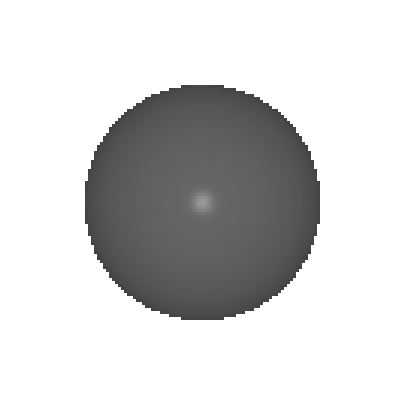

Epoch [200/1000], Loss: 1.1914
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


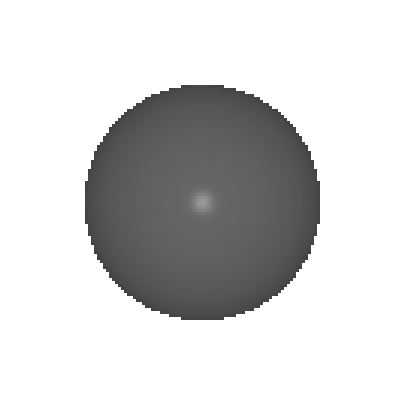

Epoch [300/1000], Loss: 1.6577
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


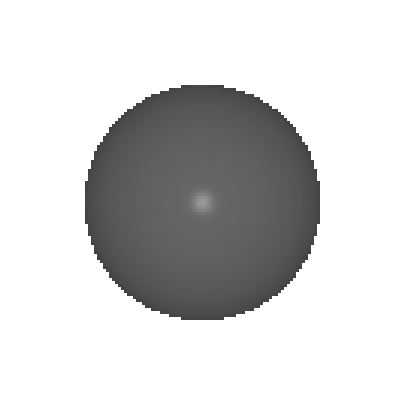

Epoch [400/1000], Loss: 1.8672
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


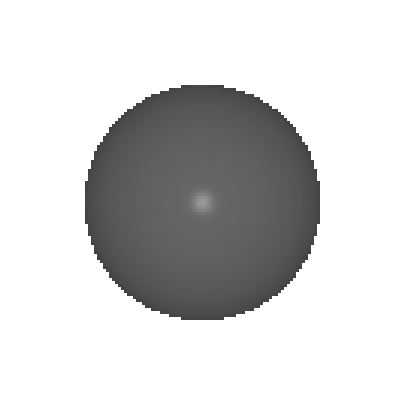

Epoch [500/1000], Loss: 1.3156
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


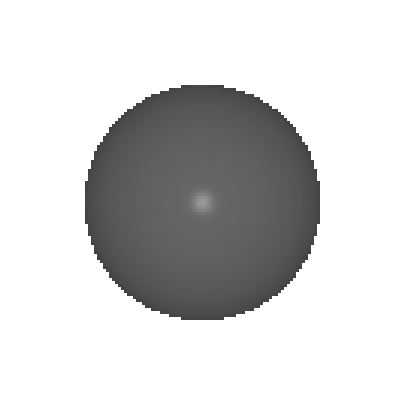

Epoch [600/1000], Loss: 1.5802
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


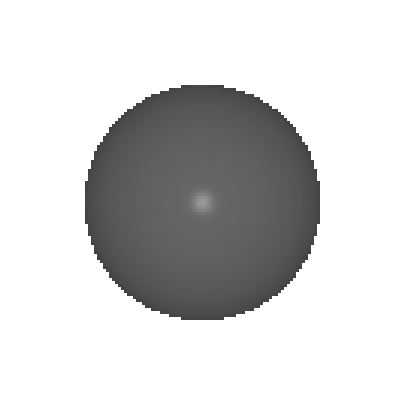

Epoch [700/1000], Loss: 1.2842
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


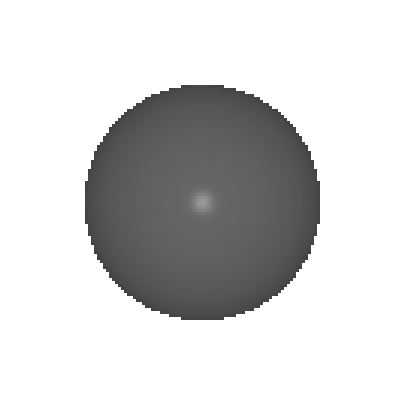

Epoch [800/1000], Loss: 1.0875
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


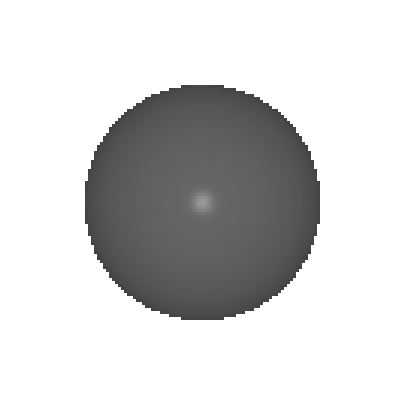

Epoch [900/1000], Loss: 1.2320
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


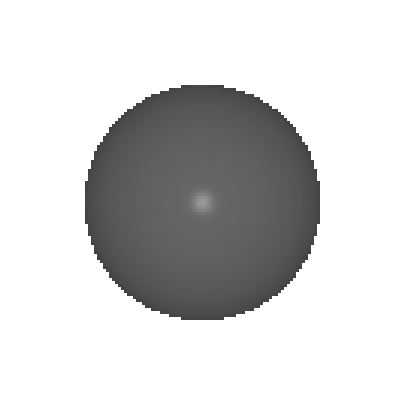

Epoch [1000/1000], Loss: 1.5968
Current stretch factors: Parameter containing:
tensor([0.1334, 0.1203, 0.1132], device='cuda:0', requires_grad=True)


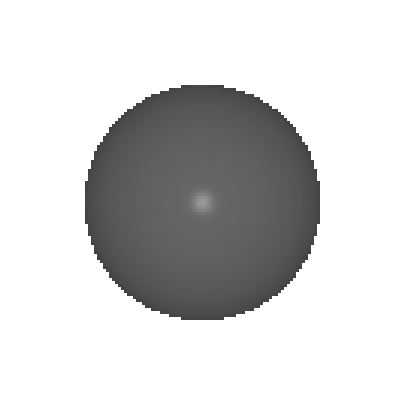

In [ ]:
losses = train_model(model, optimizer, sphere_mesh, renderer, cameras, lights, num_epochs=1000, batch_size=16, stretch_factors=stretch_factors)

# Experiments - complex mesh

following the tutorial from https://pytorch3d.org/tutorials/render_textured_meshes to upload the mesh.

In [19]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2025-05-20 21:54:20--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.121, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj.1’

cow.obj.1           100%[===================>] 322.91K  --.-KB/s    in 0.01s   

2025-05-20 21:54:20 (29.8 MB/s) - ‘data/cow_mesh/cow.obj.1’ saved [330659/330659]

--2025-05-20 21:54:20--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.121, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl.1’

cow.mtl.

In [20]:
from pytorch3d.io import load_objs_as_meshes

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

## Optimizing only the weights (control)

In [21]:
verts = mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.expand(verts.shape)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
mesh.textures = textures

In [22]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.5135


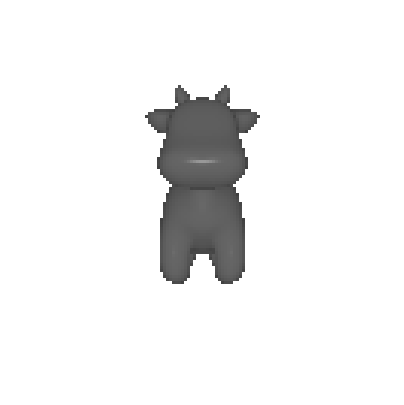

Epoch [200/1000], Loss: 0.4618


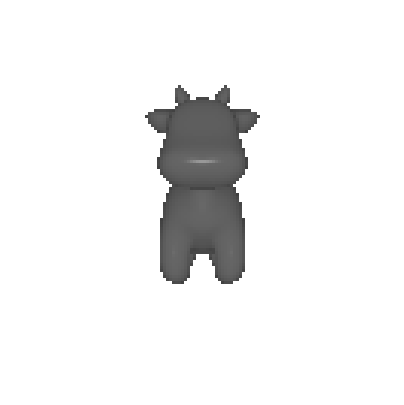

Epoch [300/1000], Loss: 0.0650


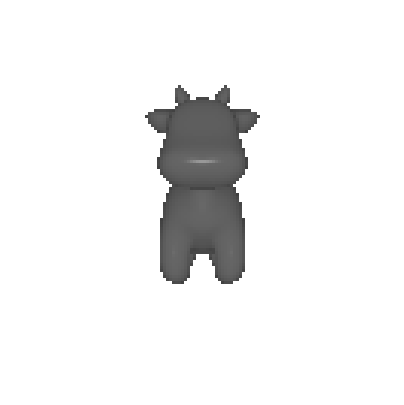

Epoch [400/1000], Loss: 0.0884


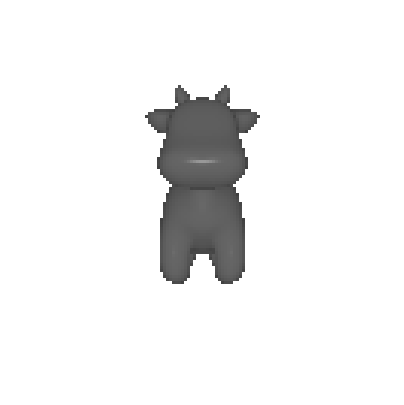

Epoch [500/1000], Loss: 0.1363


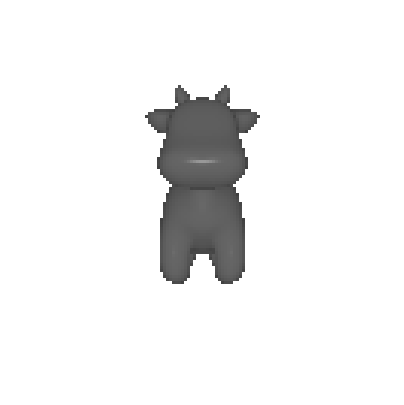

Epoch [600/1000], Loss: 0.1000


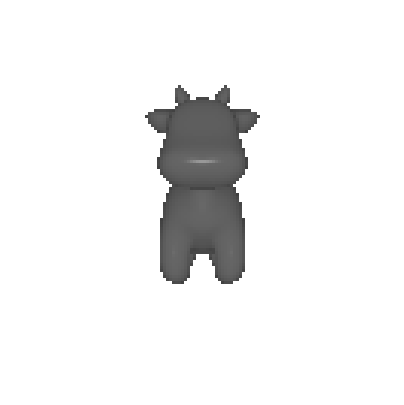

Epoch [700/1000], Loss: 0.1121


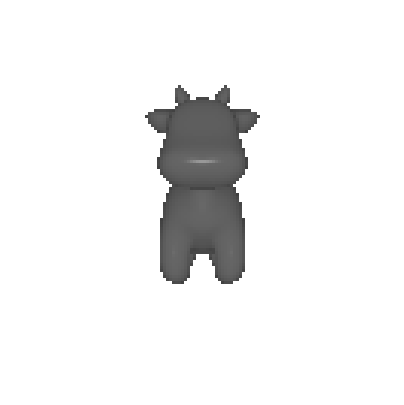

Epoch [800/1000], Loss: 0.0639


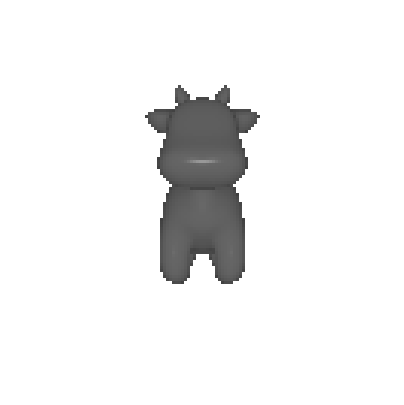

Epoch [900/1000], Loss: 0.0345


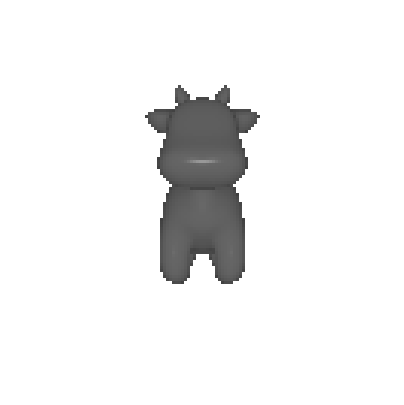

Epoch [1000/1000], Loss: 0.0229


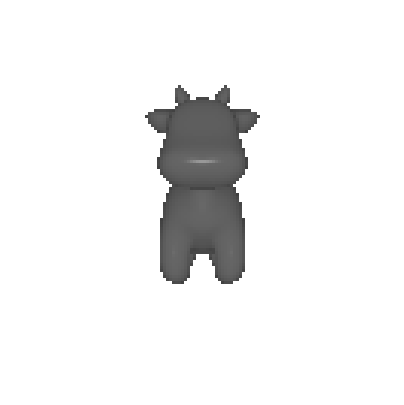

In [27]:
losses = train_model(model, optimizer, mesh, vertex_colors, renderer, cameras, lights, num_epochs=1000, batch_size=16)

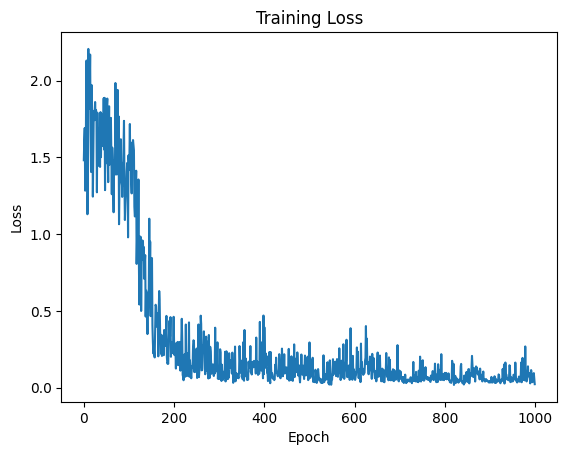

In [28]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [31]:
num_tests=500
me = test_model(model, mesh, renderer, cameras, lights, num_tests)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 2.87 (degrees).


## Optimizing the weights and colors

In [49]:
from pytorch3d.io import load_objs_as_meshes
# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

In [50]:
verts = mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.expand(verts.shape)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
mesh.textures = textures

In [51]:
model = RotationPredictor().to(device)

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

In [52]:
losses = train_model(model, optimizer, mesh, vertex_colors, renderer, cameras, lights, num_epochs=1000, batch_size=16)

RuntimeError: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.

## Optimizing the weights and shape

In [53]:
def train_model(model, optimizer, mesh, deform_verts, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=angle_loss, use_smoothing_loss=False, smoothing_weight=1):
  losses = []
  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      deformed_mesh = mesh.clone().offset_verts(deform_verts)

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      if use_smoothing_loss:
          loss += smoothing_weight * mesh_laplacian_smoothing(deformed_mesh, method="uniform")
          loss += smoothing_weight * mesh_normal_consistency(deformed_mesh)
          loss += smoothing_weight * mesh_edge_loss(deformed_mesh)

      total_loss += loss

    total_loss.backward()
    optimizer.step()

    avg_epoch_loss = total_loss.item() / batch_size
    losses.append(avg_epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        deformed_mesh = mesh.clone().offset_verts(deform_verts)
        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

In [54]:
verts = mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
mesh.textures = textures

In [56]:
model = RotationPredictor().to(device)

deform_verts = torch.full(mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.6018


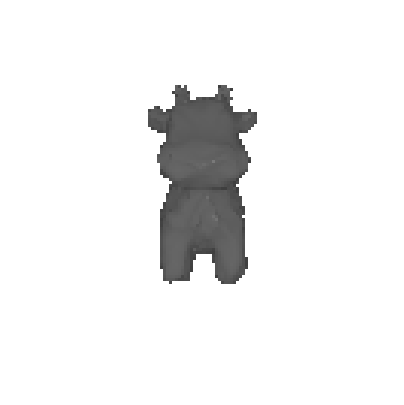

Epoch [200/1000], Loss: 1.6555


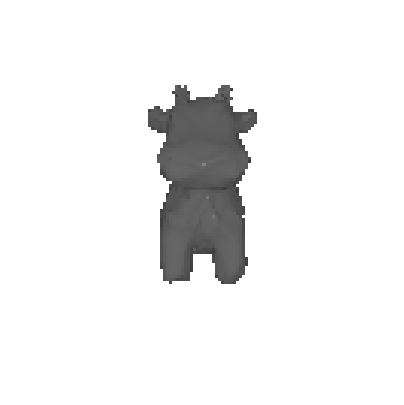

Epoch [300/1000], Loss: 1.3805


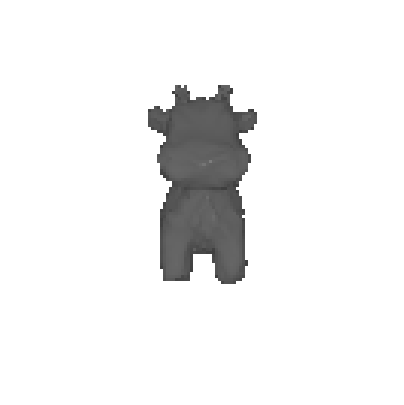

Epoch [400/1000], Loss: 1.7254


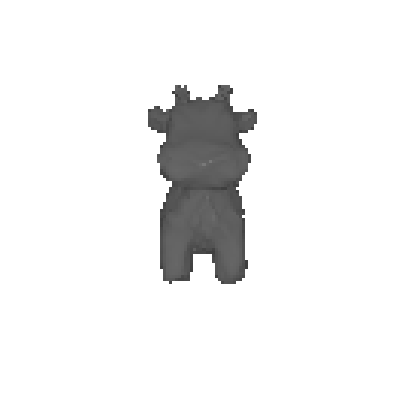

Epoch [500/1000], Loss: 0.6720


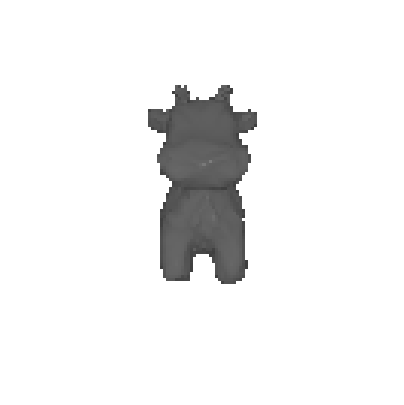

Epoch [600/1000], Loss: 0.7312


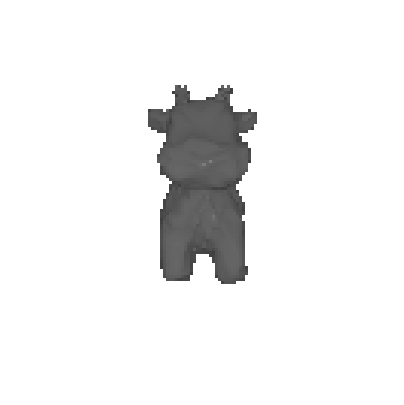

Epoch [700/1000], Loss: 0.6921


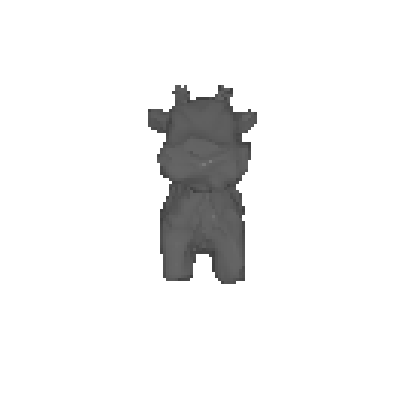

Epoch [800/1000], Loss: 0.7582


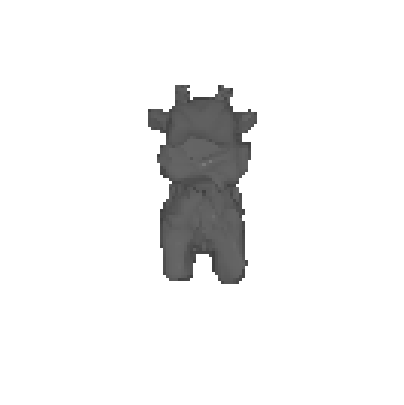

Epoch [900/1000], Loss: 0.2861


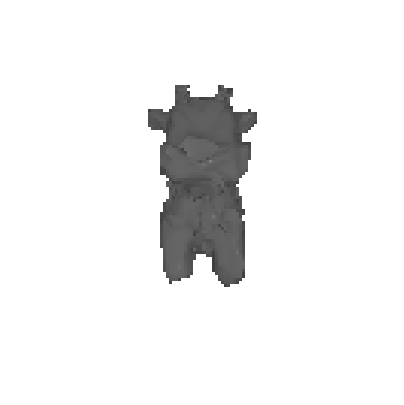

Epoch [1000/1000], Loss: 1.1062


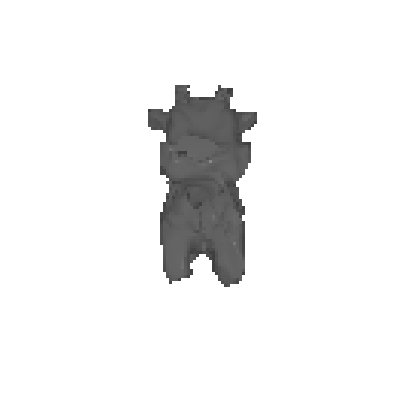

In [58]:
losses = train_model(model, optimizer, mesh, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16)

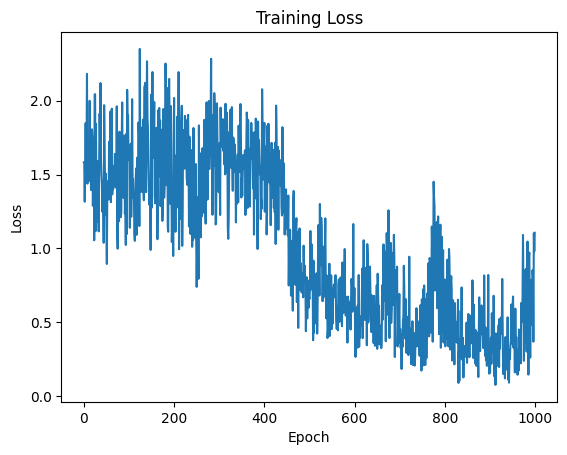

In [59]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [61]:
deformed_mesh = mesh.clone().offset_verts(deform_verts)

In [63]:
num_tests=500
me = test_model(model, deformed_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 38.00 (degrees).


## Optimizing the weights and shape with smoothing

In [64]:
verts = mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = vertex_colors.unsqueeze(0)

textures = TexturesVertex(verts_features=vertex_colors)
mesh.textures = textures

In [65]:
model = RotationPredictor().to(device)

deform_verts = torch.full(mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

/usr/local/lib/python3.11/dist-packages/pytorch3d/ops/laplacian_matrices.py:51: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))


Epoch [100/1000], Loss: 0.4635


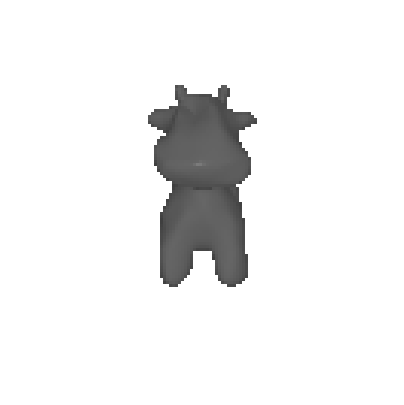

Epoch [200/1000], Loss: 0.1767


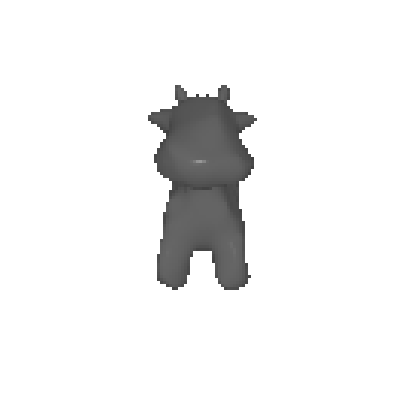

Epoch [300/1000], Loss: 0.1114


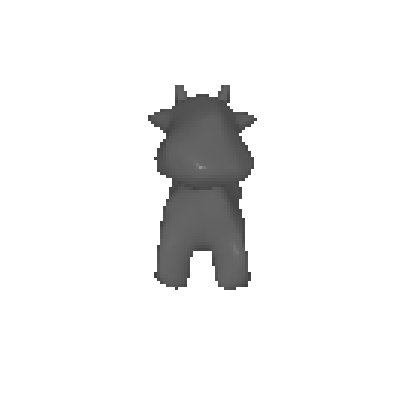

Epoch [400/1000], Loss: 0.1000


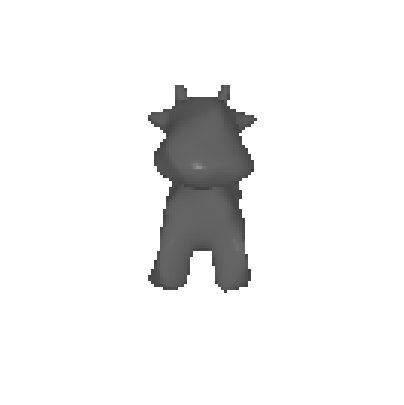

Epoch [500/1000], Loss: 0.1425


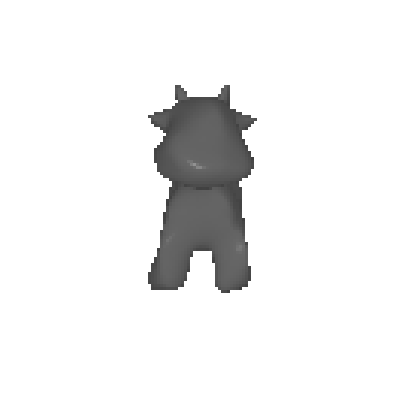

Epoch [600/1000], Loss: 0.0976


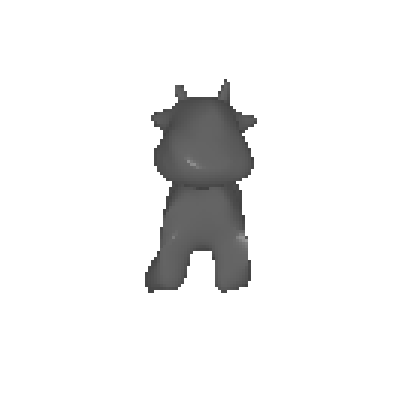

Epoch [700/1000], Loss: 0.1764


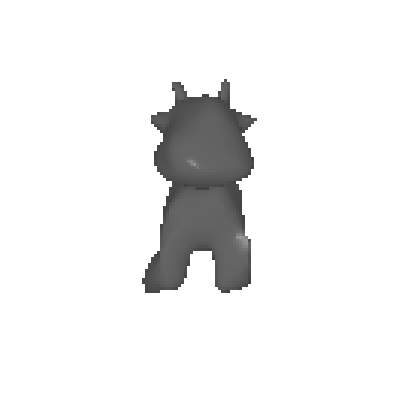

Epoch [800/1000], Loss: 0.0815


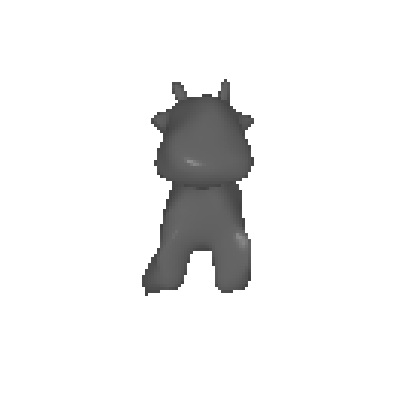

Epoch [900/1000], Loss: 0.0737


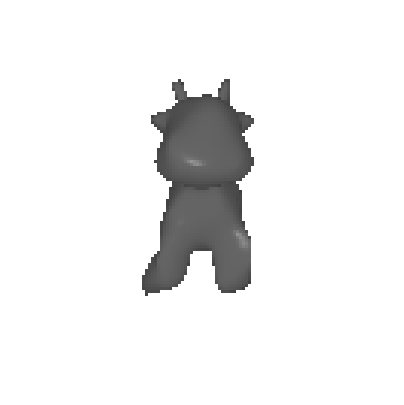

Epoch [1000/1000], Loss: 0.0686


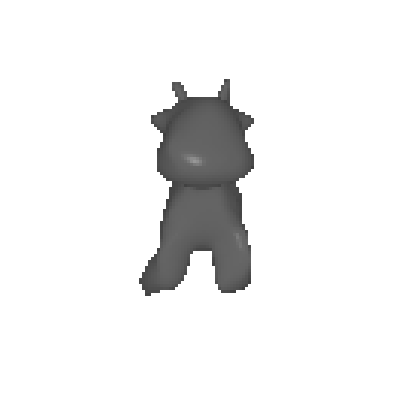

In [67]:
losses = train_model(model, optimizer, mesh, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16, use_smoothing_loss=True, smoothing_weight=1.5)

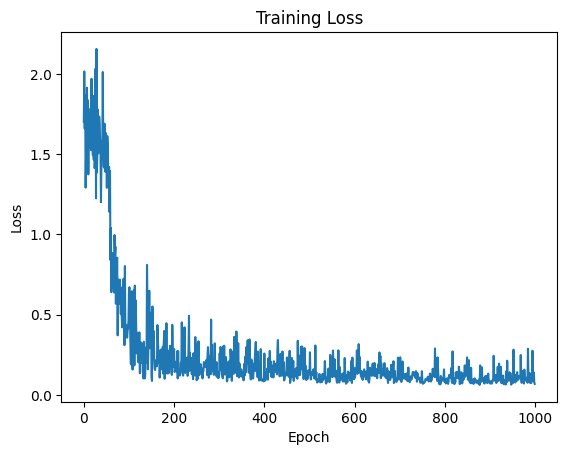

In [68]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [69]:
deformed_mesh = mesh.clone().offset_verts(deform_verts)

In [70]:
num_tests=500
me = test_model(model, deformed_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 4.64 (degrees).


## Optimizing the colors, shape and weights

In [72]:
def train_model(model, optimizer, mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=500, batch_size=32, lr=0.001, criterion=angle_loss, use_smoothing_loss=False, smoothing_weight=1):
  losses = []
  for epoch in range(num_epochs):
    total_loss = 0

    for i in range(batch_size):
      optimizer.zero_grad()

      deformed_mesh = mesh.clone().offset_verts(deform_verts)

      textures = TexturesVertex(verts_features=vertex_colors.clone())
      deformed_mesh.textures = textures

      angle = np.random.randint(0, 360)
      rotated_sphere = create_rotated_sphere(deformed_mesh, angle, device)

      image = renderer(rotated_sphere, cameras=cameras, lights=lights)
      image = image[..., :3].contiguous().permute(0, 3, 1, 2)

      predicted_angle = model(image)
      target_angle = torch.tensor([[angle * np.pi / 180.0]], device=device)

      loss = criterion(predicted_angle, target_angle)
      if use_smoothing_loss:
          loss += mesh_laplacian_smoothing(deformed_mesh, method="uniform") * smoothing_weight

      total_loss += loss

    total_loss.backward()
    optimizer.step()

    avg_epoch_loss = total_loss.item() / batch_size
    losses.append(avg_epoch_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        deformed_mesh = mesh.clone().offset_verts(deform_verts)
        visualize_sphere(deformed_mesh, vertex_colors, renderer, cameras, lights)

  return losses

In [73]:
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

mesh = load_objs_as_meshes([obj_filename], device=device)

verts = mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
mesh.textures = textures

In [74]:
model = RotationPredictor().to(device)

deform_verts = torch.full(mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 1.5110


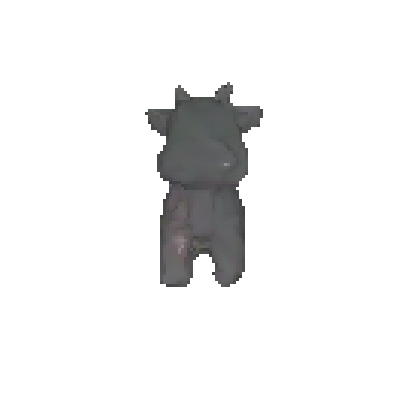

Epoch [200/1000], Loss: 0.2163


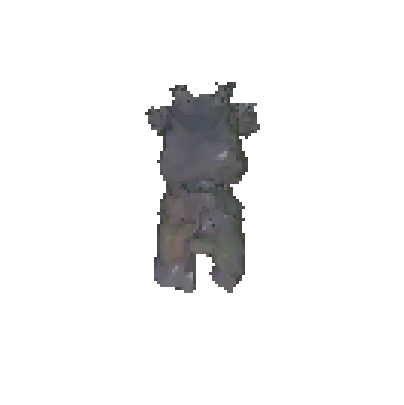

Epoch [300/1000], Loss: 0.0508


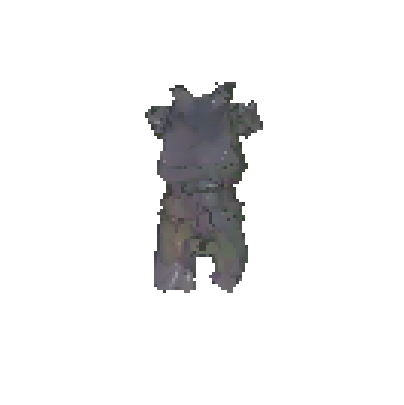

Epoch [400/1000], Loss: 0.1102


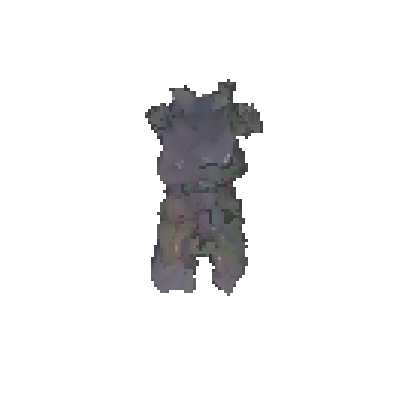

Epoch [500/1000], Loss: 0.2507


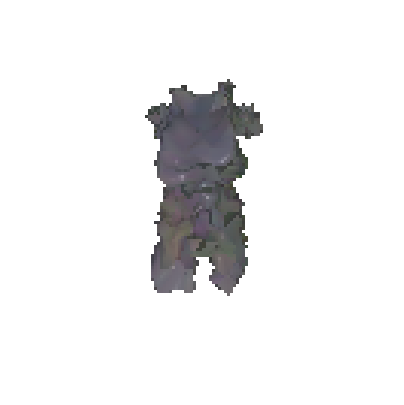

Epoch [600/1000], Loss: 0.0548


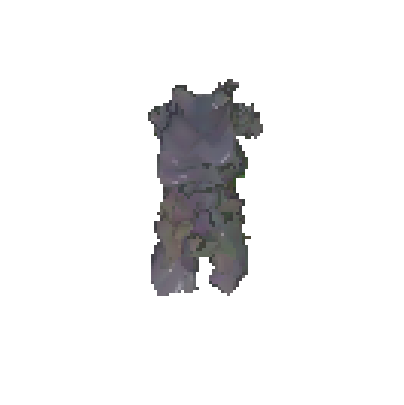

Epoch [700/1000], Loss: 0.0607


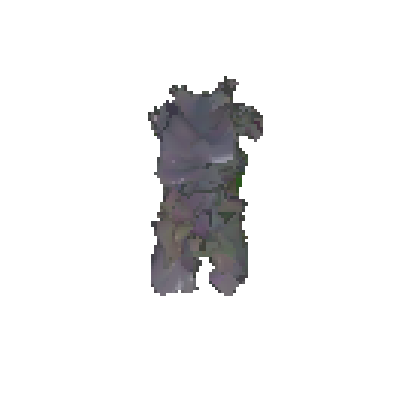

Epoch [800/1000], Loss: 0.1043


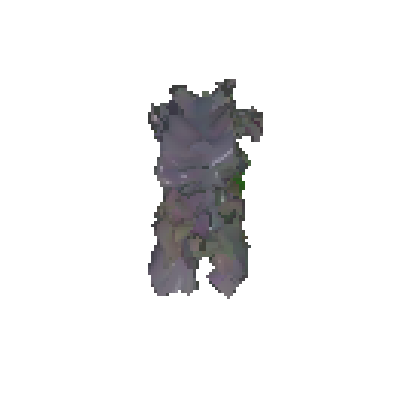

Epoch [900/1000], Loss: 0.0669


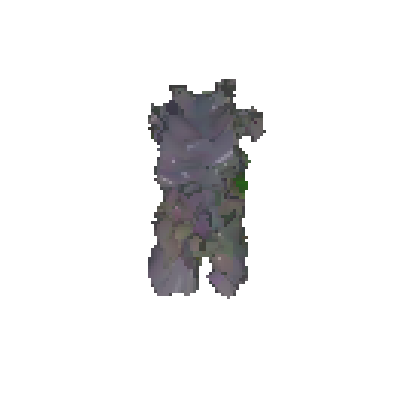

Epoch [1000/1000], Loss: 0.0701


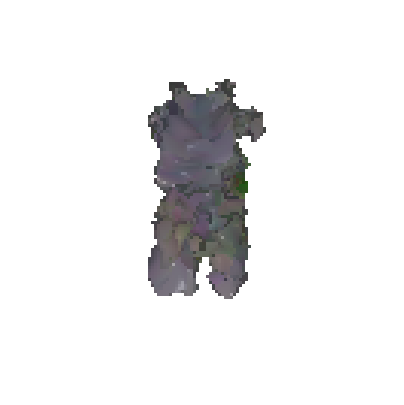

In [75]:
losses = train_model(model, optimizer, mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16)

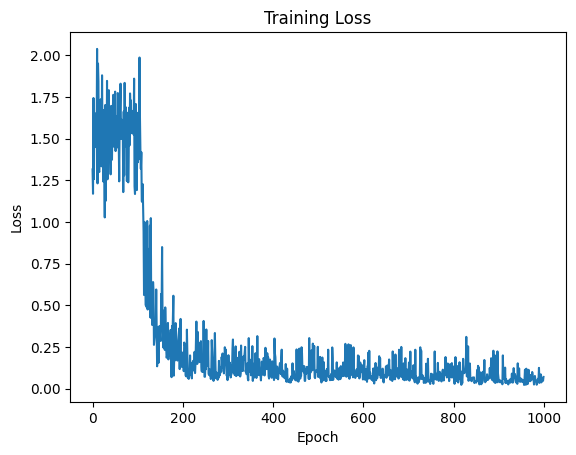

In [76]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [78]:
deformed_mesh = mesh.clone().offset_verts(deform_verts)

In [80]:
num_tests=500
me = test_model(model, deformed_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 4.37 (degrees).


## Optimizing the colors, shape and weights with smoothing

In [81]:
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

mesh = load_objs_as_meshes([obj_filename], device=device)

verts = mesh.verts_packed()

vertex_colors = torch.tensor([0.5, 0.5, 0.5], device=device)
vertex_colors = vertex_colors.repeat(verts.shape[0], 1)
vertex_colors = nn.Parameter(vertex_colors.unsqueeze(0))

textures = TexturesVertex(verts_features=vertex_colors)
mesh.textures = textures

In [82]:
model = RotationPredictor().to(device)

deform_verts = torch.full(mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)  # Preuzeto s https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

optimizer = optim.Adam([
    {'params': model.parameters()},
    {'params': [deform_verts], 'lr': 0.001},
    {'params': [vertex_colors], 'lr': 0.001}
], lr=0.001)

criterion = angle_loss

Epoch [100/1000], Loss: 0.1064


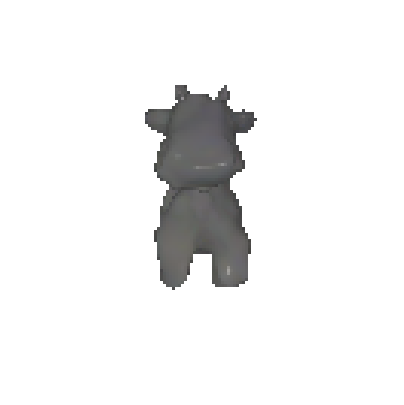

Epoch [200/1000], Loss: 0.1054


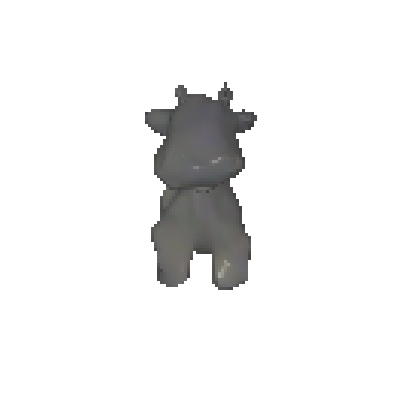

Epoch [300/1000], Loss: 0.0711


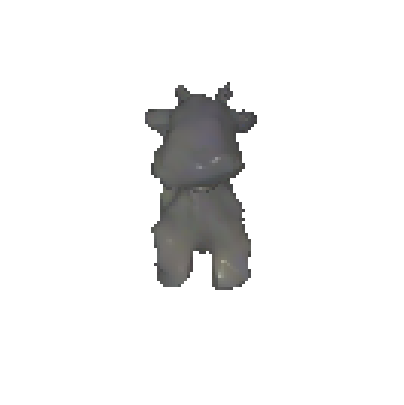

Epoch [400/1000], Loss: 0.0991


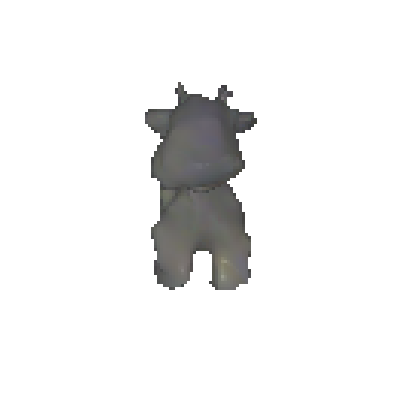

Epoch [500/1000], Loss: 0.0863


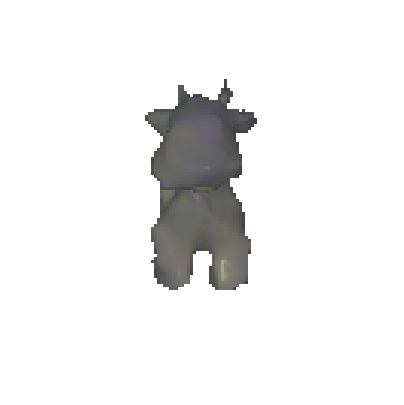

Epoch [600/1000], Loss: 0.1276


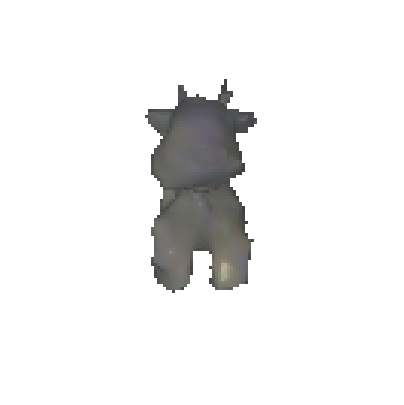

Epoch [700/1000], Loss: 0.0482


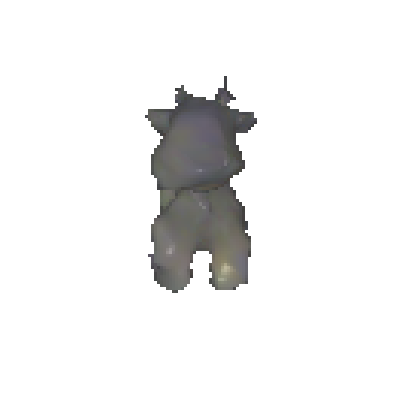

Epoch [800/1000], Loss: 0.1931


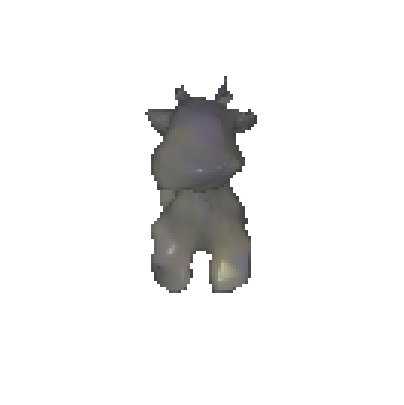

Epoch [900/1000], Loss: 0.0880


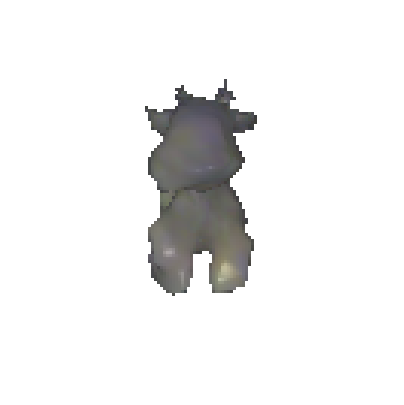

Epoch [1000/1000], Loss: 0.0324


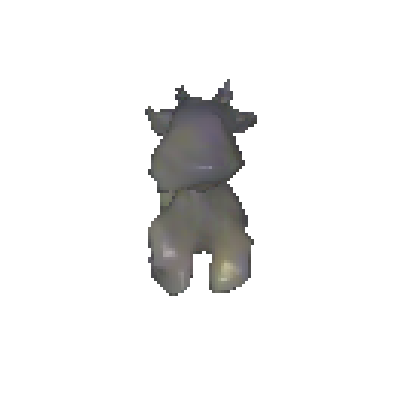

In [83]:
losses = train_model(model, optimizer, mesh, vertex_colors, deform_verts, renderer, cameras, lights, num_epochs=1000, batch_size=16, use_smoothing_loss=True, smoothing_weight=1.25)

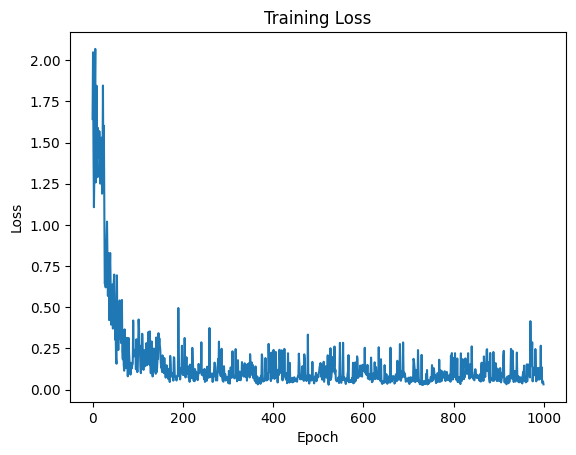

In [87]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [88]:
deformed_mesh = mesh.clone().offset_verts(deform_verts)

In [89]:
num_tests=500
me = test_model(model, deformed_mesh, renderer, cameras, lights, num_tests=500)
print(f"Mean error over {num_tests} tests: {me:.2f} (degrees).")

Mean error over 500 tests: 2.91 (degrees).
